## *Install and Import libraries*

In [ ]:
pip install swifter langid prince functions

In [ ]:
import pandas as pd
import re
import json
import csv
import random
import string
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import timedelta
from functools import reduce
from itertools import combinations
from scipy import stats
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import prince
import langid
import swifter
import functions
import pyspark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import functions
from functions import min_hash_signatures, get_top5_movies, find_similar_users, recommend_movies
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Loading and investigating the data*

We access data found in this dataset. In our spefic case the **dataset refer to Netflix audience behaviour and UK movies.**
The dataset covers user behaviour on Netflix from users in the UK to opted-in to have their anonymized browsing activity tracked.

It only includes desktop and laptop activity (which Netflix estimate is around 25% of global traffic) and is for a fixed window of time (January 2017 to June 2019, inclusive).

We may remark that data is not trusted by the platform itself but of course is relevant for *media economics.*


In [ ]:
df = pd.read_csv('netflix.csv')
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [ ]:
df.describe()

,Unnamed: 0,duration
count,671736.00000,6.717360e+05
mean,394640.50000,3.347603e+04
std,193913.62455,1.574396e+05
min,58773.00000,-1.000000e+00
25%,226706.75000,0.000000e+00
50%,394640.50000,1.400000e+01
75%,562574.25000,6.672250e+03
max,730508.00000,1.823725e+07


In [ ]:
df.shape

(671736, 8)

In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [ ]:
# check for missing values
df.isnull().sum()


Unnamed: 0      0
datetime        0
duration        0
title           0
genres          0
release_date    0
movie_id        0
user_id         0
dtype: int64

In [ ]:
# check for duplicates
df.duplicated().sum()

0

### 1. Recommendation System

In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [ ]:
# eliminating the clicks with duration 0 as it means the user did not watch the movie and may be it was a miss click
df = df[df['duration'] != 0]
df.head(15)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"Comedy, Drama",2000-04-14,584bffaf5f,759ae2eac9
13,58786,2017-01-01 21:33:26,38120.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,5b1727dc12
14,58787,2017-01-01 21:37:41,7799.0,Beasts of No Nation,"Drama, War",2015-10-16,c57e11da52,3142b4c730
17,58790,2017-01-01 22:52:08,181.0,Maravilla,"Documentary, Biography, Sport",2014-05-29,19c537b01e,93e9369e81
19,58792,2017-01-01 00:19:40,54195.0,About Last Night,"Comedy, Romance",2014-02-14,f7d088d208,78cdb81c4f
20,58793,2017-01-01 00:49:03,44413.0,Fight Club,Drama,1999-10-15,338abadc17,ac30a85c52


In [ ]:
# counting the number of clicks for each movie
number_of_clicks = df['title'].value_counts()
# top 10 movies clicked
top_10_clicked = number_of_clicks[:10]
top_10_clicked

title
Black Mirror: Bandersnatch                      2884
Bright                                          1928
Avengers: Age of Ultron                         1561
Annihilation                                    1536
Bird Box                                        1474
Deadpool                                        1425
Hot Fuzz                                        1368
The Hitman's Bodyguard                          1307
FYRE: The Greatest Party That Never Happened    1203
Captain America: Civil War                      1153
Name: count, dtype: int64

In [ ]:
top_10_clicked.index

Index(['Black Mirror: Bandersnatch', 'Bright', 'Avengers: Age of Ultron',
       'Annihilation', 'Bird Box', 'Deadpool', 'Hot Fuzz',
       'The Hitman's Bodyguard',
       'FYRE: The Greatest Party That Never Happened',
       'Captain America: Civil War'],
      dtype='object', name='title')

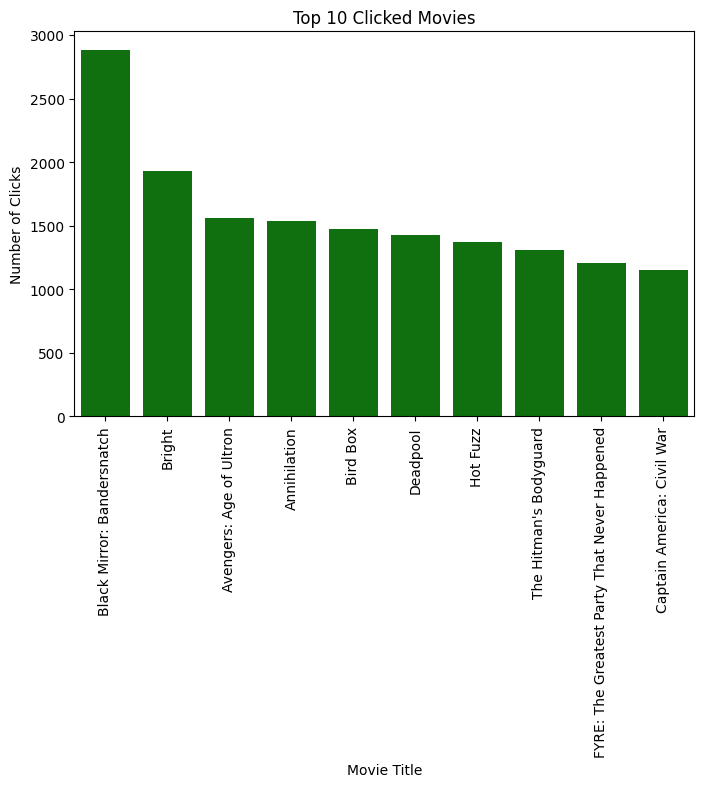

In [ ]:
# plotting the top 10 clicked movies
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_clicked.index, y=top_10_clicked.values, color='green')
plt.title('Top 10 Clicked Movies')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Clicks')
plt.show()


In [ ]:
top_10_movies_titles_genres = df[df['title'].isin(top_10_clicked.index)][['title', 'movie_id','genres']]
top_10_movies_titles_genres.drop_duplicates(inplace=True)
top_10_movies_titles_genres = top_10_movies_titles_genres[top_10_movies_titles_genres['genres'] != 'NOT AVAILABLE']

# top 10 clicked movies and their genres
top_10_movies_titles_genres


,title,movie_id,genres
757,Captain America: Civil War,572b55789d,"Action, Adventure, Sci-Fi"
22312,Deadpool,2b83f89fbe,"Action, Adventure, Comedy, Sci-Fi"
38370,Avengers: Age of Ultron,51a1a42126,"Action, Adventure, Sci-Fi"
69379,Hot Fuzz,6467fee6b6,"Action, Comedy, Mystery, Thriller"
221353,Bright,0ca8bc0382,"Action, Fantasy, Thriller"
306179,Annihilation,1f579d43c3,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr..."
323723,The Hitman's Bodyguard,261df73aa6,"Action, Comedy, Crime, Thriller"
508195,Bird Box,b4a3d3b288,"Drama, Horror, Sci-Fi"
514702,Black Mirror: Bandersnatch,e847f14da5,"Drama, Mystery, Sci-Fi, Thriller"
538537,FYRE: The Greatest Party That Never Happened,3a84965f36,"Documentary, Music"


## **1.2 Minhash Signatures**

For the hashing process, the uniques genres will be extracted from the "genres" column which will be used as **shinglings**. After that, the users will be aggregated in the same bucket if they have **similar** genres of interest.

In [ ]:
# Preprocess genres column
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

# Create a set of unique genres
genres_list = list(set(genre for genres in df['genres'] for genre in genres))


In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [ ]:
print('There are',len(genres_list), 'unique genres in the dataset, which are', genres_list)

There are 27 unique genres in the dataset, which are ['Animation', 'Film-Noir', 'Music', 'Sport', 'Mystery', 'NOT AVAILABLE', 'Family', 'Musical', 'Biography', 'Horror', 'Comedy', 'News', 'Crime', 'Adventure', 'Sci-Fi', 'War', 'Talk-Show', 'Short', 'Drama', 'Thriller', 'Romance', 'Action', 'Documentary', 'Fantasy', 'Reality-TV', 'History', 'Western']


In [ ]:
# unique user_ids
unique_users = list(df['user_id'].unique())

# Create a binary matrix where each row represents a user, and each column represents a genre
binary_matrix = pd.DataFrame(0, index=genres_list, columns=unique_users)




In [ ]:
binary_matrix.shape

(27, 120271)

In [ ]:
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mystery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']

    # Check if each genre is in the binary_matrix columns
    for genre in genres:
        if genre in binary_matrix.index:
            # Update the corresponding entry to 1
            binary_matrix.loc[genre, user_id] = 1


In [ ]:
# Drop the NOT AVAILABLE column
binary_matrix.drop('NOT AVAILABLE', axis=0, inplace=True)
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Sport,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Mystery,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
binary_matrix.shape

(26, 120271)

In [ ]:
np.random.seed(42)

# number of permutations
perms = len(genres_list)
# number of buckets
num_buckets = 1000
# Convert the binary matrix to a NumPy array
binary_matrix = binary_matrix.to_numpy()

signatures, buckets = min_hash_signatures(binary_matrix, perms, num_buckets)


#### **Justification for the choice of number of buckets:**

For a more tailored recommendation system, the assumption is made that each bucket can represent a genre, two genres, or three genres at most. Since we have 26 unique genres, the number of buckets is calculated as follows:

$$
\text {Number of Buckets} = \binom{26}{1} + \binom{26}{2} + \binom{26}{3} \text {= 2951 Buckets}
$$

## **1.3 Locality-Sensitive Hashing (LSH)**

In [ ]:
# Example usage
target_user_id = "8e1be40e32"
most_similar_users = find_similar_users(target_user_id, unique_users, signatures)

print(f"The two most similar users to the user with ID:{target_user_id} are:")
for user_id, similarity in most_similar_users:
    print(f"User ID: {user_id}, Similarity: {similarity}")

The two most similar users to the user with ID:8e1be40e32 are:
User ID: da3f0669d2, Similarity: 0.9878400682662835
User ID: 3983837e59, Similarity: 0.9860299350529271


In [ ]:
user_A_movies = get_top5_movies(most_similar_users[0][0], df, 'A')
user_B_movies = get_top5_movies(most_similar_users[1][0], df, 'B')

In [ ]:
user_A_movies

,title,movie_id,clicks,user
0,Brain on Fire,7fa4b44faf,3,A
1,Loving Vincent,c8677345e4,2,A
2,Angela's Ashes,1218186787,2,A
3,Moonstruck,3af7570904,2,A
4,Feminists: What Were They Thinking?,924c8b4002,2,A


In [ ]:
user_B_movies

,title,movie_id,clicks,user
0,Good Will Hunting,196b10fbd4,3,B
1,The Bank Job,fb219cc6c9,2,B
2,Security,b5f025e63d,1,B
3,Unlocked,a9954fc307,1,B
4,Churchill,645ae57fc7,1,B


In [ ]:
movies_to_recommend = recommend_movies(user_A_movies, user_B_movies)
print('The recommended movies are:')
for movie in movies_to_recommend:
    print(movie)

The recommended movies are:
Brain on Fire
Loving Vincent
Angela's Ashes
Moonstruck
Feminists: What Were They Thinking?


## Approach:

### Step 1: Min-Hash Signature Calculation

#### Function: `min_hash_signature(matrix, num_hashes)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.

- **Output:**
  - Min-hash signatures for each user.

- **Explanation:**
  1. For each genre, iterate through users and update the min-hash signature.
  2. Generate random hash functions to create permutations of user indices.
  3. Calculate the min-hash signature for each user by considering their liked genres.
  4. The resulting matrix (`signature_matrix`) contains min-hash signatures for all users.

### Step 2: Bucketing Users Using LSH

#### Function: `min_hash_signatures(matrix, num_hashes, num_buckets)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.
  - Number of buckets `num_buckets`.

- **Output:**
  - Min-hash signatures for each user.
  - Users grouped into buckets.

- **Explanation:**
  1. Extend the previous function to include bucketing logic.
  2. Initialize an empty dictionary (`buckets`) to store user indices for each bucket.
  3. For each genre:
     - Update min-hash signatures for users.
     - Map the min-hash signature to a bucket using a hash function.
     - Add the user to the corresponding bucket in the `buckets` dictionary.


# **2 - Grouping user together**

## *filter data*

We change default value to zero for missing values of `duration` variable

In [ ]:
# setting to 0 default missing values as could compromise future averages when doing feature engeneering
df['duration'] = df['duration'].map(lambda x: 0 if x ==-1 else x)

In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


*Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as `feature engineering`. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user.*

## Feature engeneering

## **1.** Get **favorite genre**, according to time spent seeing that genre films (duration)

> To get the favorite genre of a user we first create of set of genres

>and than we count for each user which is the most seen (based on the duration of the films)

In [ ]:
# For each row we have now a list of the genres and store to a new variable in the dataset
df['genres_list'] = df.genres.apply(lambda row: [word.strip() for word in row.split(',')])
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]"
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]"
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]"
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]"
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family,..."


### Approach

As each films has multiple labels referring to the genre we probabily want to make a dictionary from the set of genres created, update the count with the duration if that film belongs to that genre and return the favorite genre for each user.

To get the first feature we will:

1.   Create the dictionary {   (`user_id`, `genre`): `total_duration_spent_for_that_genre`}
2.   From this we create a new vocabulary where we have for each user the maximum duration and all associated genres. It occures to have more that one genres as a film can have multiple labels or more films same maximum duration.

> This dictionary will look like
{`user_id`: [`total_duration`, [ `genre1`,`genre2`,`genre3`]}
3. We convert it to a DataFrame and merge to the gf - dataframe merged by user_id



In [ ]:
# I create a dictionary were I store the genre and the total time spent on that genre
# for each user.

# Create a defaultdict to store genre durations for each user
genres_dict = defaultdict(int)

# Iterate over rows in genre_df
for index, row in gdf.iterrows():
    user_id = row['user_id']
    duration = row['duration']

    # Update the genre durations in the dictionary
    for genre in row['genres_list']:
        genres_dict[user_id, genre] += duration

In [ ]:
# An example of a key and a result of the dictionary
genres_dict[('c4e13ce589', 'Adventure')]

55279.0

In [ ]:
# Create the second dictionary to search the genre which maximum duration
column_fav_genres = defaultdict()
# Iterate over each user
for user,user_genres in genres_dict.keys():
    # Get duration
    duration = genres_dict[user,user_genres]
    # We update the dictionary with genres if those also have the maximum duration
    if user in column_fav_genres:
        # Storing the duration
        if column_fav_genres[user][0] == duration :
            # And the user
            column_fav_genres[user][1].append(user_genres)

        else:
            # Or replace the list of genre with maximum duration for each user when a find a greater duration
            if column_fav_genres[user][0]>duration:
                column_fav_genres[user] = [column_fav_genres[user][0], [user_genres]]
    # Otherwise we create a new label in the dictionary
    else:
        column_fav_genres[user] = [duration, [user_genres]]


In [ ]:
column_fav_genres['e81837c873']

[1474.0, ['Action', 'Drama', 'Thriller']]

In [ ]:
# Creating a new dictionary only for the favorite genres
for user in column_fav_genres.keys():
    column_fav_genres[user] = column_fav_genres[user][1]

In [ ]:
column_fav_genres['d7059ace40']

['Adventure', 'Family', 'Fantasy', 'Animation']

In [ ]:
# Creating a dataset from it
fav_genres = pd.DataFrame(column_fav_genres.items(), columns=['user_id','favorite_genres'])

In [ ]:
fav_genres.head()

,user_id,favorite_genres
0,1dea19f6fe,"[Comedy, Drama, Romance]"
1,544dcbc510,[Adventure]
2,7cbcc791bf,[Romance]
3,ebf43c36b6,[Comedy]
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu..."


## **2. average click duration**

Here we simply create a dataframe and computed the average duration of a click

In [ ]:
average_click = pd.DataFrame()
average_click = average_click.assign(average_click = lambda x :df.groupby(by='user_id').duration.mean()).reset_index()

average_click.head()

,user_id,average_click
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,9663.500000



## **3. time of day the user spents most of the time**

Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)


In [ ]:
df.datetime = pd.to_datetime(df.datetime)
df.release_date = pd.to_datetime(df.release_date, errors='coerce')

In [ ]:
df['hourofday'] = 0
df['hourofday'] = df.datetime.dt.hour

df.groupby(by=['user_id','hourofday'])


I create a dictionary as the following:
> {`user_id`: `duration_morning`,`duration_afternoon`,`duration_night`}
were all duration as considered as the the sum of the duration if `hourofday` is in the respective bins (slot of time).

Notice that we are considering only the starting point as information

Furthermore we split a in day in morning, afternoon and night in the following way:

part of the day (hourofday)=
\begin{cases}
\text{morning} \qquad \quad hourofday \in[05,12] \\
\text{afternoon}   \qquad hourofday \in[12,21] \\
\text{night} \qquad \qquad hourofday \in[21,05] \\
\end{cases}


In [ ]:
# Define a dictionary to store each total duration for each part. of the day
find_max_duration = defaultdict(lambda: [0,0,0])


# Iterating over the dataset to get all the information
for index,row in df.iterrows():
    user_id = row['user_id']
    hour = row['hourofday']
    duration = row['duration']
    # Add opportunly sum up in the corrispondence position in the list
    if 5<=hour<12:
        # list[0] if MORNING
        find_max_duration[user_id][0] += duration
    elif 12<=hour<21:
        # list[1] for AFTERNOON
        find_max_duration[user_id][1] += duration
    elif 21<=hour or hour<5:
        # list[2] if NIGHT
        find_max_duration[user_id][2] += duration

In [ ]:
# An example
find_max_duration['7cbcc791bf']

[0, 21496.0, 3816.0]

In [ ]:
# Create a new dictionary were for each user I return 'Morning/Afternoon/Night'
# leveraging the dictionary fin_max_duration
max_hourofday = defaultdict()

i=0
for id in find_max_duration.keys():
    max_list = find_max_duration[id].index(max(find_max_duration[id]))
    if max_list ==0:
        max_hourofday[id] = 'Morning'
    if max_list ==1:
        max_hourofday[id] = 'Afternoon'
    if max_list ==2:
        max_hourofday[id] = 'Night'

In [ ]:
# Creating a DataFrame from the dictionary
timeofday = pd.DataFrame(list(max_hourofday.items()), columns=['user_id', 'timeofday'])

In [ ]:
timeofday.head()

,user_id,timeofday
0,1dea19f6fe,Morning
1,544dcbc510,Afternoon
2,7cbcc791bf,Afternoon
3,ebf43c36b6,Afternoon
4,a57c992287,Afternoon


### **4. old movie lover/new school user**

Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

We set this variable to `oldmovies` when an user saw more films released before 2010 rather then film released after that year.

In [ ]:
df['oldmovie'] = False
df['oldmovie'] = df.release_date.dt.year < 2010

# Group by 'user_id' and calculate the sum of True and False for each user
user_preference = df.groupby('user_id')['oldmovie'].sum()

oldmovie_df = pd.DataFrame(user_preference).reset_index()
# Create a new column 'oldmovie_preference' based on the condition
oldmovie_df['oldmovie'] = df['user_id'].map(user_preference > (df.groupby('user_id')['oldmovie'].count() - user_preference))

# Convert the boolean values to 'oldmovies' or 'newmovies'
oldmovie_df['oldmovie'] = oldmovie_df['oldmovie'].map({True: 'oldmovies', False: 'newmovies'})



In [ ]:
oldmovie_df.head()

,user_id,oldmovie
0,00004e2862,oldmovies
1,000052a0a0,newmovies
2,000090e7c8,newmovies
3,000118a755,newmovies
4,000296842d,newmovies


## **5. average time**
Average time spent a day by the user (considering only the days he logs in)

In [ ]:
df1 = pd.DataFrame()
df1[['days', 'averagetime_day', 'user_id']] = df[['datetime', 'duration', 'user_id']]

# Extract the date from the 'datetime' column
df1['date'] = df1['days'].dt.date

# Group by date and perform your desired aggregation
grouped_data = df1.groupby(by = ['date','user_id']).agg({'averagetime_day': 'mean'}).reset_index().drop(columns=['date'])
# Group by user_id and calculate the mean of 'averagetime_day'
user_avg_data = grouped_data.groupby('user_id')['averagetime_day'].mean().reset_index()

In [ ]:
# Considering minutes insted of seconds
user_avg_data['averagetime_day'] = user_avg_data['averagetime_day'].transform(lambda x :x/60)

In [ ]:
user_avg_data.head()

,user_id,averagetime_day
0,00004e2862,0.000000
1,000052a0a0,44.871296
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,143.319444


## We finally have all our 5 variables + `user_id`

In [ ]:
# We merge our five variables
merged_df = pd.merge(fav_genres, average_click, on='user_id')
merged_df = pd.merge(merged_df, oldmovie_df, on='user_id')
merged_df = pd.merge(merged_df, user_avg_data, on='user_id')
merged_df = pd.merge(merged_df, timeofday, on='user_id')


In [ ]:
merged_df.head()

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon


In [ ]:
merged_df.to_json('/content/drive/MyDrive/ADM4/5variables.json', orient='records', lines=True)

## *Let's add some more feature*

This new features should be relevant for to respect to `user_id`

Consider at least 10 additional features that can be generated for each user_id. In the end, you should have for each user at least 15 features.

## **1. day of the week preference**

Harnessing the power of data analytics, we're about to decipher the movie-watching patterns that unfold as the calendar shifts from Monday to Sunday. Are weekends the undisputed champions of cinematic indulgence, or does the magic of movies extend its influence throughout the workweek as well?

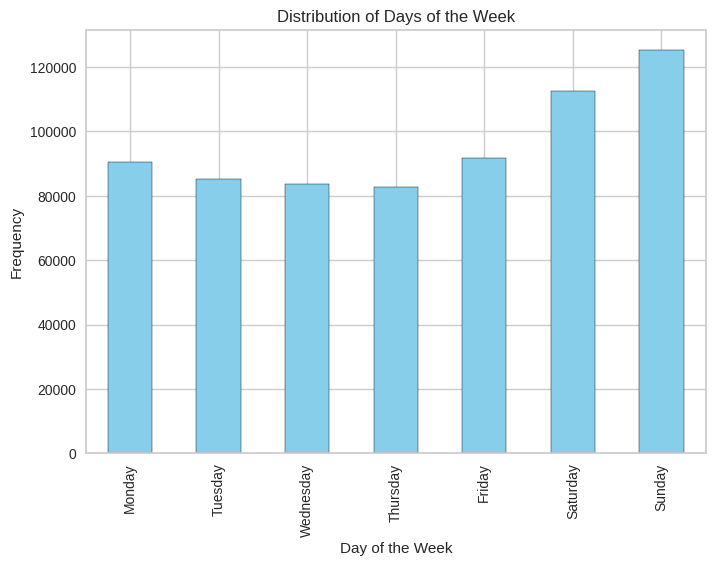

In [ ]:
# Create a new DataFrame 'week' with 'day_of_week' and 'user_id'
week = df[['datetime', 'user_id']].copy()

# Plotting the distribution of days of the week
day_counts = week['day_of_week'].value_counts()
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

day_counts.plot(kind='bar', edgecolor='black', color='skyblue')

# Plot the histogram
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Days of the Week')
plt.show()

Analyzing the data reveals a compelling trend: the enchantment of cinematic experiences intensifies over the weekends, with Saturdays and Sundays emerging as the prime days for movie watching.

We define a new *feature* `weekend` as:

weekend=
\begin{cases}
False \qquad \qquad \text{is a weekday} \\
True \qquad \qquad \text{is in the weekend} \\
\end{cases}

We can leverage this new variable to better understand the behaviour of the

In [ ]:
week['day_of_week'] = df['datetime'].dt.day_name()
weekend = ['Saturday', 'Sunday']

# map into True/False values if the user watch in the film in the weekendor
week['isweekend'] = week['day_of_week'].map(lambda x : x in weekend)
# Group by 'user_id'
weekend_preference = week.groupby('user_id')['isweekend'].sum()
day_count= week.groupby('user_id')['isweekend'].count()

# Column 'weekend' based on the condition normalizing by the number of days
week['weekend'] = week['user_id'].map(
    lambda user_id: (day_count[user_id]/7 < weekend_preference[user_id]/2)
)

In [ ]:
week = week.drop(columns=['datetime', 'day_of_week','isweekend']).drop_duplicates()

In [ ]:
week

,user_id,weekend
0,1dea19f6fe,True
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,False
...,...,...
671702,45414be0ec,True
671705,783ec67e84,True
671727,89c715f3a4,True
671730,9207e1499b,True


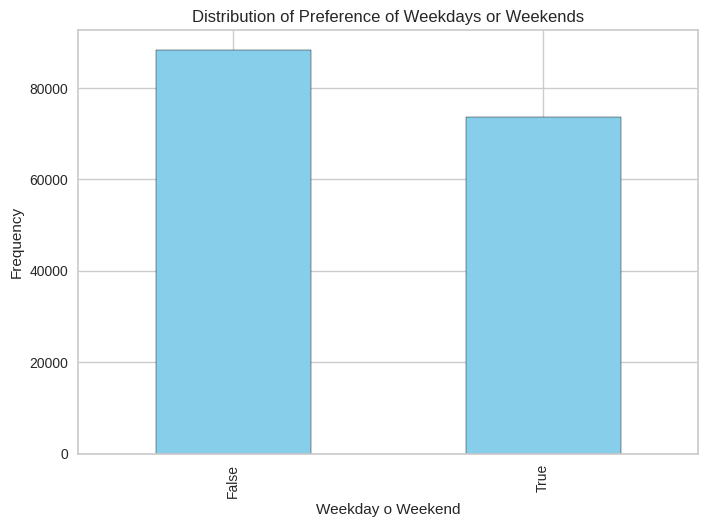

In [ ]:
weekend_weekday= week['weekend'].value_counts()
weekend_weekday.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Weekday o Weekend')
plt.ylabel('Frequency')
plt.title('Distribution of Preference of Weekdays or Weekends')

# Display the plot
plt.show()

## **2. english title**
Could the presence of non-English titles be the key to unraveling distinctive user preferences?

As we embark on this cinematic journey, we initiate the variable `count_nonenglish` to meticulously tally every film search with a non-English title. The intrigue deepens as we explore the diverse landscape of film preferences.

### Approch:

we leverage the package langid to check the language of the title and store our variable consequently

In [ ]:
def is_english(text):
    '''
    This function take a string of text and return wether all text is English
    Returns a boolean object
    '''
    language, confidence = langid.classify(text)
    return language == 'en'

In [ ]:
isenglish = df[['user_id','title']]

# Use tqdm's progress_apply for a progress bar
isenglish['isenglish'] = tqdm(df['title'].swifter.apply(lambda x: is_english(x)))

Pandas Apply:   0%|          | 0/671736 [00:00<?, ?it/s]

100%|██████████| 671736/671736 [00:00<00:00, 2718500.69it/s]
<ipython-input-79-ce457ab2d174>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isenglish['isenglish'] = tqdm(dataset['title'].swifter.apply(lambda x: is_english(x)))


In [ ]:
isenglish

,user_id,title,isenglish
0,1dea19f6fe,"Angus, Thongs and Perfect Snogging",True
1,544dcbc510,The Curse of Sleeping Beauty,True
2,7cbcc791bf,London Has Fallen,True
3,ebf43c36b6,Vendetta,False
4,a57c992287,The SpongeBob SquarePants Movie,True
...,...,...,...
671731,57501964fd,Oprah Presents When They See Us Now,True
671732,d4fcb079ba,HALO Legends,False
671733,4a14a2cd5a,Pacific Rim,True
671734,0b8163ea4b,ReMastered: The Two Killings of Sam Cooke,True


In [ ]:
# Evaluating the numbers of films not in english that the user searched for
isenglish['count_notenglish'] = isenglish.groupby('user_id')['isenglish'].transform(lambda x: x.count() - x.sum())

# Dropping auxiliar columns
isenglish = isenglish.drop(columns=['title','isenglish']).drop_duplicates()


In [ ]:
isenglish

,user_id,count_notenglish
0,1dea19f6fe,0
1,544dcbc510,0
2,7cbcc791bf,1
3,ebf43c36b6,5
4,a57c992287,5
...,...,...
161913,45414be0ec,1
161914,783ec67e84,0
161915,89c715f3a4,0
161916,9207e1499b,0


## **3. series addiction**

If an user saw at least a film which belongs to a series

First of all **we define a film to be part of a series if**:

> in the title there is a number (this decision was taken looking at the unique values of the titles) which:
  >> does not start at the beginning of the title

  >> is not a percentage (e.g. 100)
  
  >> is not a float number like (1.0) or (40,000)

  >> 1st (appears not to assign the number of series of a film)

  >> 3D information qithin the title

  >> mixed string like QR45EE700

  >> digits more that 3 digits, assuming that a series of film will not exceed 999

  >> reference to years like 90s or '42

All examples cited were occurenced of real tiles in the dataset

Finally we define the feature through boolean values as follows:


series_addicted=
\begin{cases}
False \qquad \qquad \text{never seena film which belongs to a series} \\
True \qquad \qquad \text{has seen at least one series} \\
\end{cases}


In [ ]:
series = df[['title','user_id']].copy()

def remove_punctuation(input_string):
    '''
    Function wich return a string
    '''
    translation_table = str.maketrans("", "", string.punctuation)
    no_punctuation = input_string.translate(translation_table)
    return no_punctuation

def process_title(title):
    '''
    Finds wethere a film belongs or not to a series of films based on the ruled decided
    for this dataset
    '''
    joined_title = title
    joined_title = re.sub(r"\([^)]*\)|3D|\d{1,3}%|\d{1,2}[,|.]\d{1,3}|\d{2}s|'\d{2}|\d{1,3}%|\d{1,3}[st|th|rd]", '', joined_title)
    joined_title1 = ''.join(remove_punctuation(joined_title).split())
    return not bool(re.match(r'^\d{1,4}|(\ )?[A-Z]?\d{1,6}\ ', joined_title)) and not joined_title1.isalpha()

# Create a new column 'is_series' based on those condition
series['is_series'] = series['title'].apply(process_title)

In [ ]:
# Now for each user we count how many series he saw
number_series = pd.DataFrame(series.groupby('user_id')['is_series'].sum()).reset_index()

# We convert this feature to boolean when a user has seen at least a film of the series
number_series['is_series'] = number_series['is_series'].apply(lambda x: True if x > 0 else False)

In [ ]:
number_series

,user_id,is_series
0,00004e2862,False
1,000052a0a0,False
2,000090e7c8,False
3,000118a755,False
4,000296842d,False
...,...,...
161913,fffd9bf758,True
161914,fffe7b777b,False
161915,fffeac83be,False
161916,ffff2c5f9e,False


## **4. film-coholic**

We establish the count of films the user has either viewed or queried by utilizing the variable `title`.

This variable acts as a pivotal tool in capturing the cinematic footprint of the user, allowing us to meticulously track their engagement with movies, whether it be through actual viewing experiences or inquisitive searches.

In [ ]:
# Copy the important information we need for our new variable
num_films = df[['user_id','title']].copy()

# Grouping by user we count the number of films
num_films['num_films'] = num_films.groupby('user_id')['title'].transform('size')

# Adjust for merging
num_films = num_films.drop(columns=['title']).reset_index(drop=True).drop_duplicates()

In [ ]:
num_films

,user_id,num_films
0,1dea19f6fe,1
1,544dcbc510,12
2,7cbcc791bf,6
3,ebf43c36b6,15
4,a57c992287,26
...,...,...
671702,45414be0ec,1
671705,783ec67e84,1
671727,89c715f3a4,1
671730,9207e1499b,1


## **5. movie clicker**

It seems **someone is undecided about which movie to watch, but have they at least started watching one**? Let's define the variable `onefilm` to capture the cinematic journeys that begin with a click but may or may not reach the final credits:


movie_clicker=
\begin{cases}
False \qquad \qquad \text{definigthly a movie-clicker} \\
True \qquad \qquad \text{has seen at least one film} \\
\end{cases}


In [ ]:
# Now for each user, check if they have seen at least one film with duration greater than 0
onefilm = df[['user_id', 'title', 'duration']].copy()

# Create a binary column indicating whether the user has seen at least one film (1) or not (0)
onefilm['onefilm'] = (onefilm.groupby('user_id')['duration'].transform('max') > 0).astype(bool)

# Drop duplicates to keep only unique user_id rows
onefilm = onefilm[['user_id', 'onefilm']].drop_duplicates()


In [ ]:
onefilm

,user_id,onefilm
0,1dea19f6fe,False
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,True
...,...,...
671702,45414be0ec,False
671705,783ec67e84,False
671727,89c715f3a4,False
671730,9207e1499b,True


## **6. unveiling the enchantment of length titles**

Ever heard of sesquipedalophobia? It's the quirky fear of long words, and while we're not here to induce word-induced anxiety, we couldn't resist a playful nod to it.

**Introducing *`avg_lentitle`* our not-so-fearsome variable that measures the average length of movie titles.**

 No need to panic; we're just unraveling the delightful dance of letters in the world of cinema. After all, a title's length may hold the secret to its allure, or perhaps it's just a whimsical journey through the labyrinth of letters

 Emphasizing inclusivity, **this metric considers all movies users searched for, providing a nuanced understanding of their preferences beyond the ones they've already watched**. This comprehensive approach enhances our ability to extract meaningful insights from their cinematic exploration

In [ ]:
# Leverage titles to find some patters in user preferences
lentitle = df[['user_id','title']].copy()
# Computing the length of title
lentitle['lentitle']= lentitle['title'].apply(lambda x: len(x))
# And extracting the average grouping by user
lentitle['avg_lentitle'] = lentitle.groupby('user_id')['lentitle'].transform(lambda x: x.mean().astype(int))
# Adjust dataset for merging operations
lentitle = lentitle.drop(columns=['title','lentitle']).drop_duplicates()

In [ ]:
lentitle

,user_id,avg_lentitle
0,1dea19f6fe,34
1,544dcbc510,15
2,7cbcc791bf,13
3,ebf43c36b6,13
4,a57c992287,14
...,...,...
671702,45414be0ec,18
671705,783ec67e84,14
671727,89c715f3a4,15
671730,9207e1499b,23


## **7. average duration of films seen**

Considering only the films he actually saw, **we consider the duration of the time spent to see it in minuted**. Notice that of course, only through our data, we cannot know if the user saw entirely the film.

We could eventually get an idea of that after looking at the result.

This isn't directly the goal of the variable. We can rather interprete it as if an user preferes long films of multiple episodes of a series eventually of go for short one.

In [ ]:
avg_duration = df[['user_id', 'duration']].copy()

# Filter films with duration > 0 and count the number of films seen for each user
film_seen = df[df['duration'] > 0].groupby('user_id')['title'].count().reset_index()
film_seen.columns = ['user_id', 'film_seen']

# Merge the film_seen count with avg_duration DataFrame
avg_duration = pd.merge(avg_duration, film_seen, on='user_id')

# Calculate the average duration for each user
avg_duration['sum_duration']  = avg_duration.groupby('user_id')['duration'].transform('sum')
# Consider the average only of films actually seen and consider minutes
avg_duration['avg_duration'] = np.where(avg_duration['sum_duration'] > 0, avg_duration['sum_duration'] /(60*avg_duration['film_seen']), 0).round(3)

In [ ]:
avg_duration = avg_duration.drop(columns=['duration','film_seen','sum_duration']).drop_duplicates()

In [ ]:
avg_duration

,user_id,avg_duration
0,544dcbc510,155.375
12,7cbcc791bf,105.467
18,ebf43c36b6,31.392
33,a57c992287,145.148
59,c5bf4f3f57,50.990
...,...,...
591778,065de46f55,11396.167
591779,098fe851e4,69.050
591780,5463651e3a,10.000
591781,9207e1499b,709.867


## **8. genre diversity search**

Dive into the intriguing world of Genre Diversity Search, **a metric that delves into the spectrum of cinematic tastes**. If marked as "True," it indicates that a user has ventured into films across more than six diverse genres. On the flip side, if marked as "False," it suggests a cinematic journey centered around a set of consistent genres. This metric provides a nuanced glimpse into a user's preference for diverse cinematic experiences, offering valuable insights into the breadth of their film choices.

### Approach
From the variable genre_list we create a set and group by user. Then we can identify the preferences of the user watching the cardinality of the set of the single user


genre_diversity=
\begin{cases}
False \qquad \qquad \text{different cinematic tastes ( # genres > 6)} \\
True \qquad \qquad \text{limited cinematic tastes ( # genres < 6)} \\
\end{cases}

In [ ]:
genre_diversity= df[['user_id','genres_list']].copy()

genre_diversity['genre_set'] = genre_diversity['genres_list'].apply(lambda x: set(x))

# Group by 'user_id' and aggregate the sets
grouped = genre_diversity.groupby('user_id')['genre_set'].agg(lambda x: set.union(*x)).reset_index()

# Counting the different genres an user searched for
grouped['number_genres'] = grouped.groupby('user_id')['genre_set'].transform(lambda x: len(*x))

# Transforming it in adicotomic variabile according to a parameter fixed at 6, whose decision was taken after observing
# a plot of gropued['genres_diversity']
grouped['genre_diversity'] = grouped['number_genres'].transform(lambda x : 'Genre Diverse' if x>4 else 'Not Genre Diverse')

In [ ]:
grouped = grouped.drop(columns=['genre_set','number_genres'])

In [ ]:
grouped

,user_id,genre_diversity
0,00004e2862,Not Genre Diverse
1,000052a0a0,Genre Diverse
2,000090e7c8,Not Genre Diverse
3,000118a755,Not Genre Diverse
4,000296842d,Not Genre Diverse
...,...,...
161913,fffd9bf758,Not Genre Diverse
161914,fffe7b777b,Not Genre Diverse
161915,fffeac83be,Genre Diverse
161916,ffff2c5f9e,Genre Diverse


## **9. time between clicks**

Calculate the average time in minutes between two consecutive clicks for each user. Some users might binge-watch content in quick succession, while others may have more spaced-out viewing habits.

### Approch

We take the dfference of the sorted datetime by user and consider the average of these differences.


In [ ]:
gapclick = df[['user_id','datetime']].copy()

# Convert 'datetime' column to datetime format
gapclick['datetime'] = pd.to_datetime(gapclick['datetime'])

# Sort DataFrame by 'user_id' and 'datetime'
gapclick_sorted = gapclick.sort_values(by=['user_id', 'datetime'])

# Calculate the time difference between consecutive rows for each user_id
gapclick_sorted['time_diff'] = gapclick_sorted.groupby('user_id')['datetime'].diff().apply(lambda x: x.seconds/60)

# Calculate the average time gap for each user_id
gapclick_sorted['avg_clickgap']  = gapclick_sorted.groupby('user_id')['time_diff'].transform('mean').round(3)

In [ ]:
gapclick = gapclick_sorted.drop(columns=['time_diff','datetime']).drop_duplicates()

In [ ]:
gapclick

,user_id,avg_clickgap
223802,00004e2862,NaN
84304,000052a0a0,374.955
305472,000090e7c8,NaN
379093,000118a755,73.900
520133,000296842d,190.167
...,...,...
105488,fffd9bf758,NaN
149015,fffe7b777b,NaN
142253,fffeac83be,581.643
129867,ffff2c5f9e,17.517


## **10. first-day fanatic**

In this new feature we want to store if a user is a first fanatic or not examinig how muchtime from the released_date and the time he saw the film has passed.

Indeed we computed as :

$$\displaystyle \dfrac{1}{n_{u_i}} \sum_{i=1}^n \text{duration dicotomic} \cdot \left( \text{release date -  datetime}\right)$$

where `n` is the number of films seen by each user.

Notice that it is influnced by how many times saw that film so it can be normalized based on how many time an author has seen that film. It can be interested therefore to compute also that feature, which we're doing next.

In [ ]:
df[df['release_date']=='NOT AVAILABLE']

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
54,58827,2017-01-01 23:51:31,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,83e994b53d
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,NOT AVAILABLE,NOT AVAILABLE,9e898f41e0,8aff21d9e9
71,58844,2017-01-01 13:23:40,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,0b1635a78e
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,NOT AVAILABLE,NOT AVAILABLE,be096a4a5a,3cf91dd97e
118,58891,2017-01-01 17:20:26,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,ea05759d9b
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,NOT AVAILABLE,NOT AVAILABLE,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,NOT AVAILABLE,NOT AVAILABLE,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,NOT AVAILABLE,NOT AVAILABLE,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,NOT AVAILABLE,NOT AVAILABLE,d558d9be6f,0b8163ea4b


In [ ]:
# Extract the date from the 'datetime'
#columndataset = pd.to_datetime(dataset.datetime)
df.datetime = pd.to_datetime(df.datetime)
df['release_date'] = df.apply(lambda row: row['datetime'] if row['release_date'] == 'NOT AVAILABLE' else row['release_date'],axis=1)
df.release_date = pd.to_datetime(df.release_date)

gap_time = df[['user_id','datetime','release_date','title']].copy()
gap_time['datetime'] = gap_time['datetime'].dt.year
gap_time['release_date'] = gap_time['release_date'].dt.year

# Calculate the time gap in years
gap_time['gap_time'] = gap_time['datetime'] - gap_time['release_date']

# Taking the average of realeased date only for the films which have non-zero gap time
gap_time['gap_time_avg'] = gap_time.groupby(['user_id','title'])['gap_time'].transform(lambda x: x.mean() if (x != 0).any() else 0)

# Take the average of film where film have gp_time_avg not zero. Some are setted to 0 when NOT AVAILABLE
gap_time['gap_time_avg'] = gap_time.groupby('user_id')['gap_time_avg'].transform(lambda x: x.mean() if (x != 0).any() else 0).round(0)


gap_time['gap_time_avg'] = gap_time['gap_time_avg'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
gap_time = gap_time.drop(columns=['datetime','release_date','gap_time','title']).drop_duplicates()

In [ ]:
gap_time

,user_id,gap_time_avg
0,1dea19f6fe,9.0
1,544dcbc510,5.0
2,7cbcc791bf,4.0
3,ebf43c36b6,6.0
4,a57c992287,6.0
...,...,...
671702,45414be0ec,0.0
671705,783ec67e84,10.0
671727,89c715f3a4,2.0
671730,9207e1499b,6.0


## final merge of the 15 features

we load the dataset we saved cointaining the first five variables

In [ ]:
file_path="/content/drive/MyDrive/ADM4/5variables.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
firstvariable = pd.DataFrame(data_list)

In [ ]:
firstvariable.head()

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon


In [ ]:
# 1- and weekeday or weekend
merged_df = pd.merge(firstvariable, week, on='user_id')
# 2- title isinglish
merged_df = pd.merge(merged_df, isenglish, on='user_id')
# 3- is a series film
merged_df = pd.merge(merged_df, number_series, on='user_id')
# 4- number of films searched
merged_df = pd.merge(merged_df, num_films, on='user_id')
# 5- if an user have seen at least one film
merged_df = pd.merge(merged_df, onefilm, on='user_id')
# 6- length of the title of film
merged_df = pd.merge(merged_df, lentitle, on='user_id')
# 7- average duration of films by user_id
merged_df = pd.merge(merged_df, avg_duration, on='user_id')
# 8- genre diversity
merged_df = pd.merge(merged_df, grouped, on='user_id')
# 9- average seconds between two clicks
merged_df = pd.merge(merged_df, gapclick, on='user_id')
# 10- average seconds between two clicks
merged_df = pd.merge(merged_df, gap_time, on='user_id')

# Set user_id as index
merged = merged_df.set_index('user_id', inplace =True)

In [ ]:
merged_df.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


we stored the final dataset so we can easily retreived it in the future times without renunning also prepossesing operations

In [ ]:
merged_df.to_json('/allvariables.json', orient='records', lines=True)


# **2.2 - Feature selection**


In [52]:
file_path="/allvariables.json"

# Initialize to store JSON file
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Load the single row of the JSON
        data = json.loads(line)
        # Add it to the list
        data_list.append(data)

# Now 'data' is a list
allvariable = pd.DataFrame(data_list)

In [53]:
allvariable.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


**To attemp to use the variable `favorite_genre` we consider only a single of the list of first genres we pick randomly**. We previously made an assumption to be conservative and try to store all favorite genre but at this point we need further assumption as we cannot store or consider frequencies of all possible duplets, triplets: indeed that choice would lead dealing with a very sparse histogram.

**We should find some useful aggregation** as:
>  taking a random element of list

>> Notice that it is more consistent than taking into account the first element as the genres in the list are ordered and therefore we then expect (and proved but not showing here) to have either a favorite genres or a genres that starts with A, B , C, D, ... such as Action, Comedy, Documentary, ...

In [54]:
allvariable2 = allvariable.copy()

# We selecet a random element in the list of favorite genres
allvariable2['first_genre'] = allvariable2['favorite_genres'].apply(lambda x: random.choice(x))

# and then drop the auxiliar column
allvariable2 = allvariable2.drop(columns = ['favorite_genres'])

In [9]:
allvariable2['first_genre'].head()

0       Comedy
1    Adventure
2      Romance
3       Comedy
4       Family
Name: first_genre, dtype: object

## *data consistency: outliers, skewness, normalization*

In the pursuit of a deeper understanding of our dataset, we embark on an exploration of variable distributions. **Examining these distributions allows us to identify potential outliers, assess the stability of variance**, and consider the advantageous implications of stabilizing variance.


---



Stabilizing variance becomes crucial in enhancing the reliability of statistical analyses and modeling.

Multiple Factor Analysis (MFA) similarly emphasizes variable distribution scrutiny, maintaining variance stability. MFA's flexibility accommodates diverse variable types, ensuring equitable contributions for a balanced representation of impact. MFA benefit from stabilizing variance, fostering robust and interpretable results.

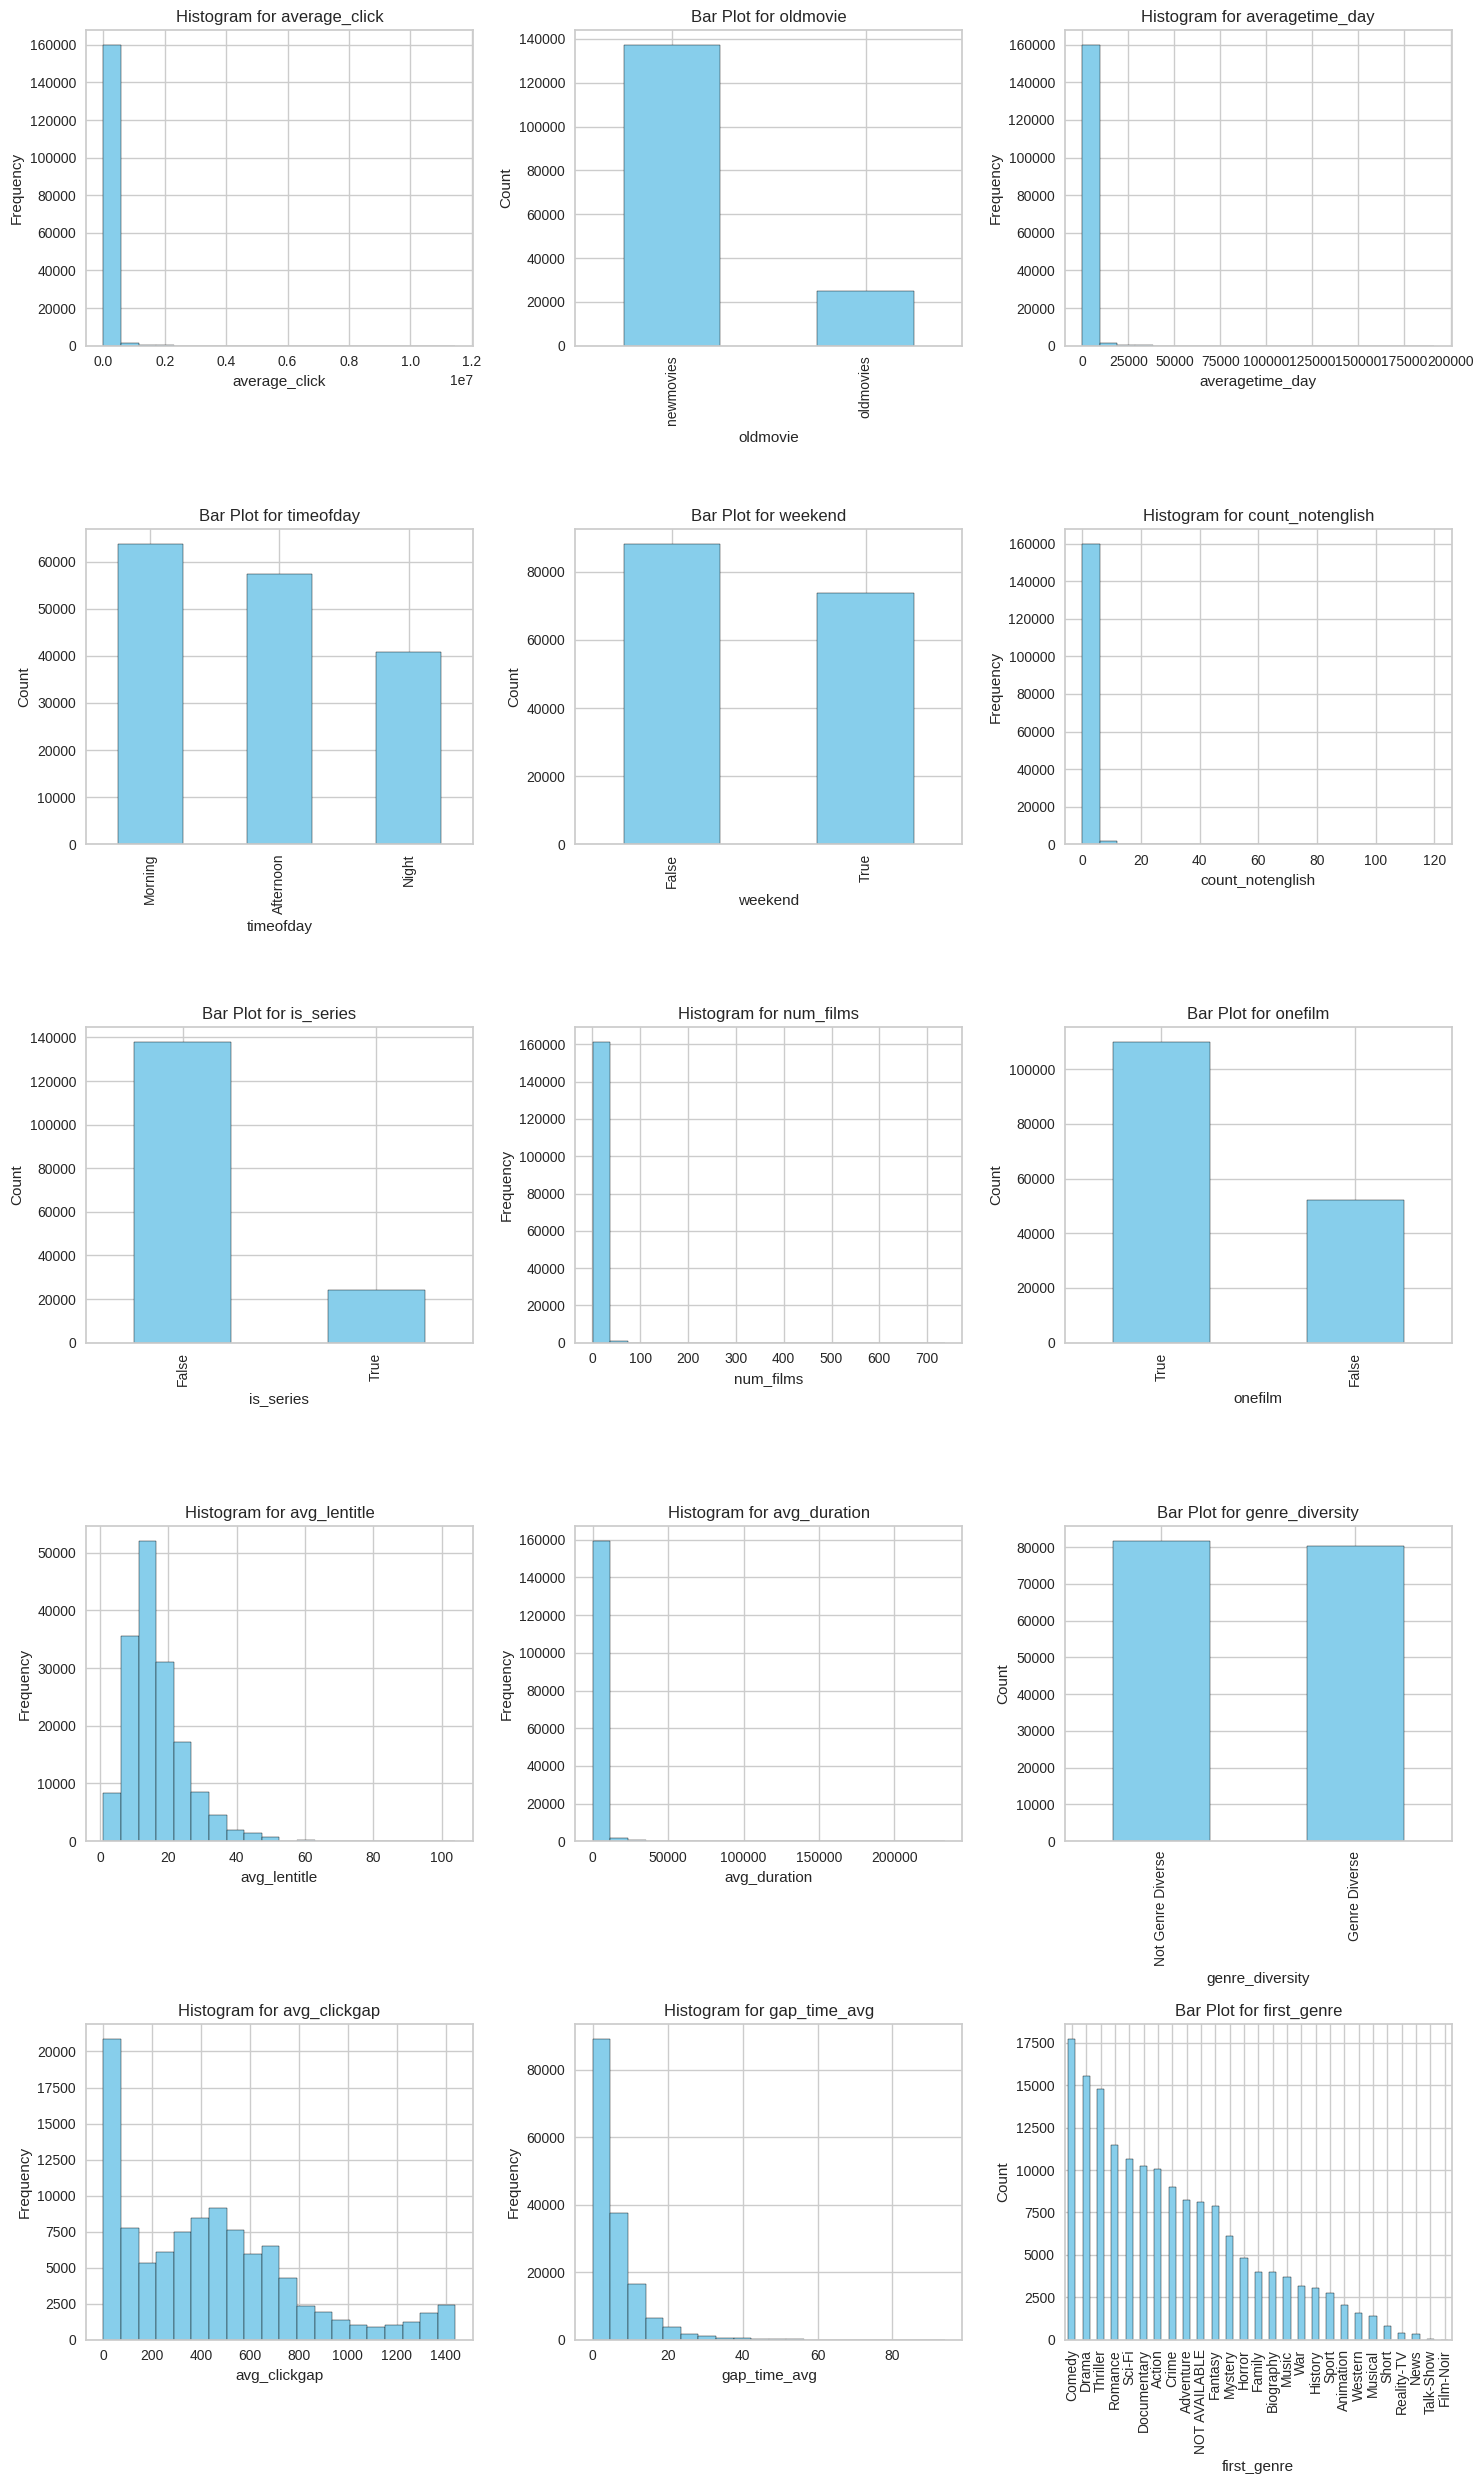

In [ ]:
# Get the list of all columns
all_columns = allvariable2.columns

# Set the number of columns per row
columns_per_row = 3  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(all_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(all_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In light of this observation, **we choose to address outliers to ensure the robustness of our analysis**. The presence of outliers in the dataset, particularly in variables showcasing a skewed distribution, can disproportionately influence model performance. The decision to limit outliers is motivated by the desire to mitigate any undue impact on the results, as the data doesn't seem entirely consistent with high or otherwise anomalous values. **Importantly, these outliers do not originate from our intermediate transformations but may reflect inherent variability within the dataset.**

## **Handle `outliers`**

We remove the outliers from the following variables:  `average_duration` and `averagetime_day`

Moreover, to address the impact of outliers on the integrity of our analysis, **we choose to employ a robust approach by removing outliers based on quantile thresholds**. This method allows us to focus on the majority of the data while mitigating the influence of extreme values that may distort the overall patterns.

In most of the cases there were no values under the first percentile (the minimum coincided with the first quartile) but addressed the values above the third quartile which were erally sparse and highly distant, somehow incoherent.

In [55]:
# Select only specific columns
selected_columns = ['avg_duration', 'averagetime_day']
df_selected = allvariable2[selected_columns]

In [56]:
# We chose a high value as data is sparse
# Setting of a multiplicative rate to tune the range of the quantiles
iqr_multiplier = 3.0

# Iterate through each column in the selected DataFrame
for column in df_selected.columns:
    # Calculate the first quartile, third quartile, and interquartile range
    Q1 = df_selected[column].quantile(0.25)
    Q3 = df_selected[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers for the current column
    outliers = ((df_selected[column] < (Q1 - iqr_multiplier * IQR)) |
                (df_selected[column] > (Q3 + iqr_multiplier * IQR)))

    # Calculate the median only for the current column
    column_median = df_selected.loc[~outliers, column].median()
    # Replace outliers with the median of the column
    df_selected.loc[outliers, column] = column_median

<ipython-input-56-4a934bda1ae9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[outliers, column] = column_median
<ipython-input-56-4a934bda1ae9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[outliers, column] = column_median


#### *Now that we plotted the data and reduced the range of the data, still we feel we're missing something. Some variables looks like a log-normal. Indeed it has the tipical behaviour of a log-normal: light tail for extreme right-values of the distribution.*

For example `averagetime_day` meansure the seconds in a day: maximum value that assumed before was definightly out of range. So our decision is supported not only to reach optimal results in the analysis but also logical coherence; which is overall the most important thing.

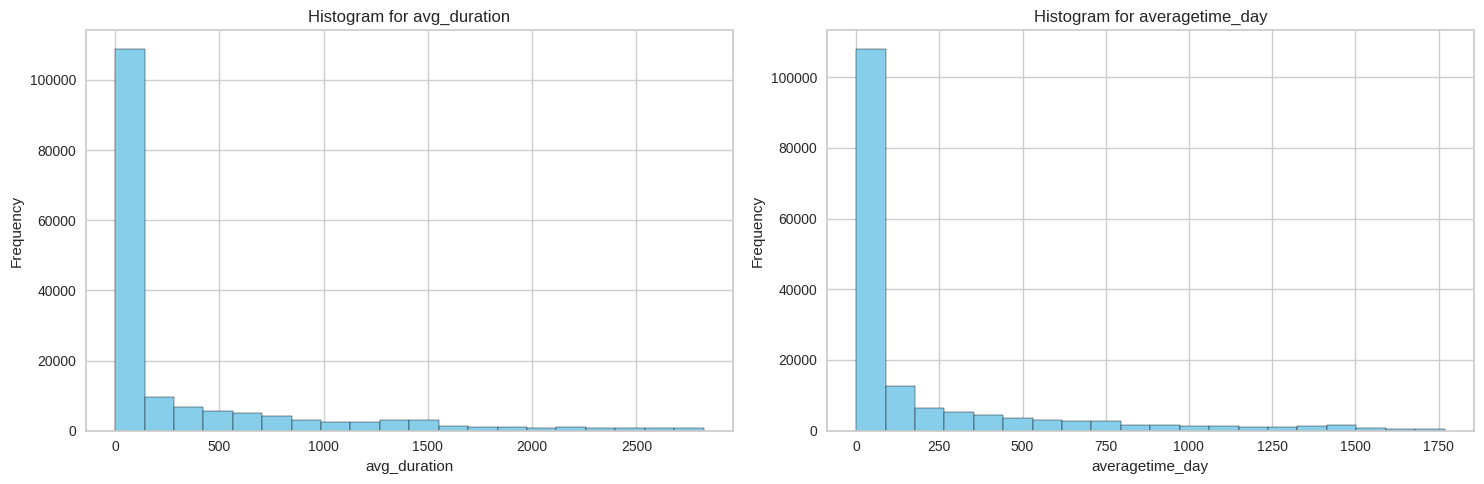

In [ ]:
# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flatten the 2D array into a 1D array
axes = axes.flatten()

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(df_selected):
    # Check if the column is numerical
    if df_selected[column].dtype in ['float64', 'int64']:
        axes[i].hist(df_selected[column], edgecolor='black', color='skyblue', bins=20)
        axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


## **Robust Data Transformation**

**Transformations** like logarithm **are often used for various purposes in data analysis and statistics** as mentioned before. We report a brief list of reason how is worth apply such transformation: **normalization of distributions, variance stabilization, handling non-linear relationships, reducing the effect of outliers**.

Apart from  normalization and variance stabilization we indeed notice that same variables such as `num_films` we can assume that as the number of films increases the number of user which saw that number of films will decres exponentially an not linear, or also quadratic but not linear. Indeed this transformation could be a good solution to handle non-linear relationships.



After have checked all variable we may want to apply logaritmic transformation to the following variables: `average_duration`, `num_films`, `averagetime_day`, `avg_lentitle`, `average_click`, `count_notenglish`

In [57]:
# Select columns of interest, included "avg_duration" e "averagetime_day"
selected_columns = [ "avg_lentitle",  "avg_duration", "averagetime_day", "average_click", "count_notenglish", "num_films"]

# Iterate through selected columns
for column in selected_columns:
    # Apply the logarithmic transformation to the column
    transformed_data = np.log1p(allvariable2[column])

    #Update the column in the DataFrame with the transformed values
    allvariable2[column] = transformed_data


In [13]:
allvariable2.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0.000000,False,0.693147,False,3.555348,0.000000,Not Genre Diverse,NaN,9.0,Comedy
1,7.613407,newmovies,3.825840,Afternoon,True,0.000000,True,2.564949,True,2.772589,5.052257,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,0.693147,True,1.945910,True,2.639057,4.667835,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,1.791759,True,2.772589,True,2.639057,3.477911,Genre Diverse,214.389,6.0,Comedy
4,9.176215,newmovies,4.972029,Afternoon,False,1.791759,True,3.295837,True,2.708050,4.984620,Genre Diverse,446.923,6.0,Family


### *plot of the transformed data (without outliers)*

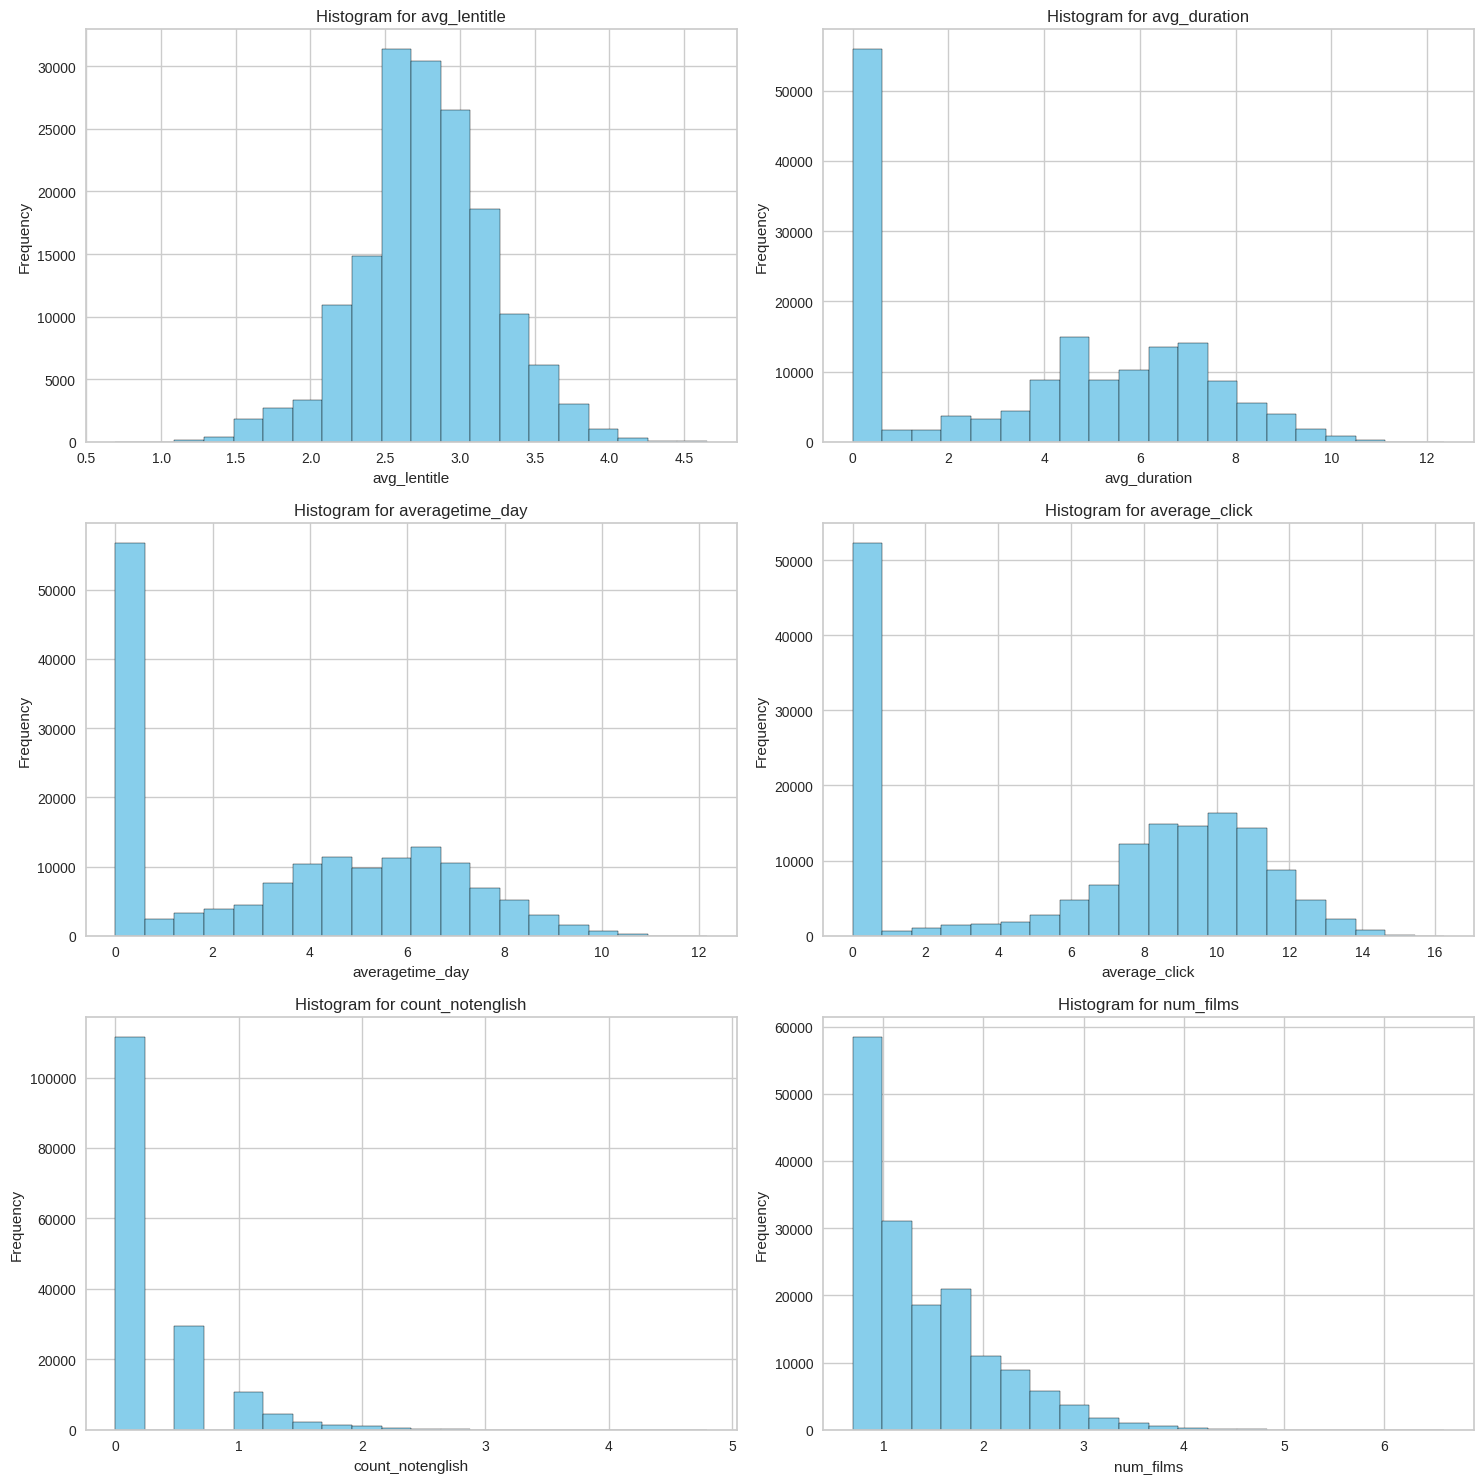

In [58]:
# Set the number of columns per row
columns_per_row = 2  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(selected_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(selected_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [59]:
# Imputing data with the median as data as skewed and average will not be that robust
allvariable2['avg_clickgap'].fillna(allvariable2['avg_clickgap'].median(), inplace=True)
allvariable2['gap_time_avg'].fillna(allvariable2['gap_time_avg'].median(), inplace=True)

We check there're no Nan values

In [16]:
# Verifies the presence of NaN
print(allvariable2.isnull().sum())

average_click       0
oldmovie            0
averagetime_day     0
timeofday           0
weekend             0
count_notenglish    0
is_series           0
num_films           0
onefilm             0
avg_lentitle        0
avg_duration        0
genre_diversity     0
avg_clickgap        0
gap_time_avg        0
first_genre         0
dtype: int64


## Correlation check

Before engaging in the reduction of the data matrix, it is crucial to conduct a preliminary examination of correlations among the variables and appropriately address any issues. Deep scrutiny of correlations helps identify potential challenges such as multicollinearity, which can impact the reliability of matrix reduction results. Careful consideration must be given to excluding variables that exhibit strong correlations with others, as these may introduce redundancy and distort the interpretation of underlying factors.

#### correlation for quantitative variables

In [17]:
numerical_var = allvariable2[['average_click','averagetime_day', 'count_notenglish', 'num_films',  'avg_lentitle',
       'avg_duration', 'avg_clickgap', 'gap_time_avg','first_genre']]

In [ ]:
# 1. Matrice di Correlazione per Variabili Numeriche
correlation_matrix =numerical_var.corr()

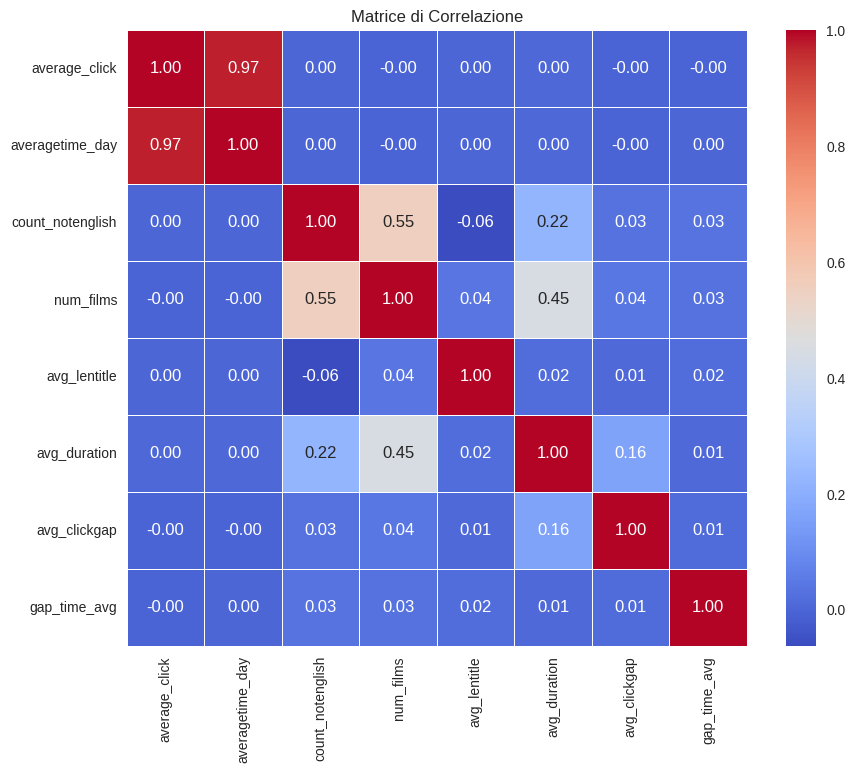

In [19]:
# Creare un heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

After examining the correlation matrix, it becomes evident that there is a correlation between the variables `average_click` and `averagetime_day` in the dataset.

Averagetime_day is dropped

In [20]:
allvariable2.drop(['averagetime_day'], axis=1, inplace=True)


#### Association for categorial variables

In [21]:
categorical_var = allvariable2[['oldmovie', 'timeofday', 'weekend','is_series', 'onefilm',
                              'genre_diversity']]

In [22]:
categorical_var.head()

,oldmovie,timeofday,weekend,is_series,onefilm,genre_diversity
0,newmovies,Morning,True,False,False,Not Genre Diverse
1,newmovies,Afternoon,True,True,True,Genre Diverse
2,newmovies,Afternoon,True,True,True,Genre Diverse
3,newmovies,Afternoon,True,True,True,Genre Diverse
4,newmovies,Afternoon,False,True,True,Genre Diverse


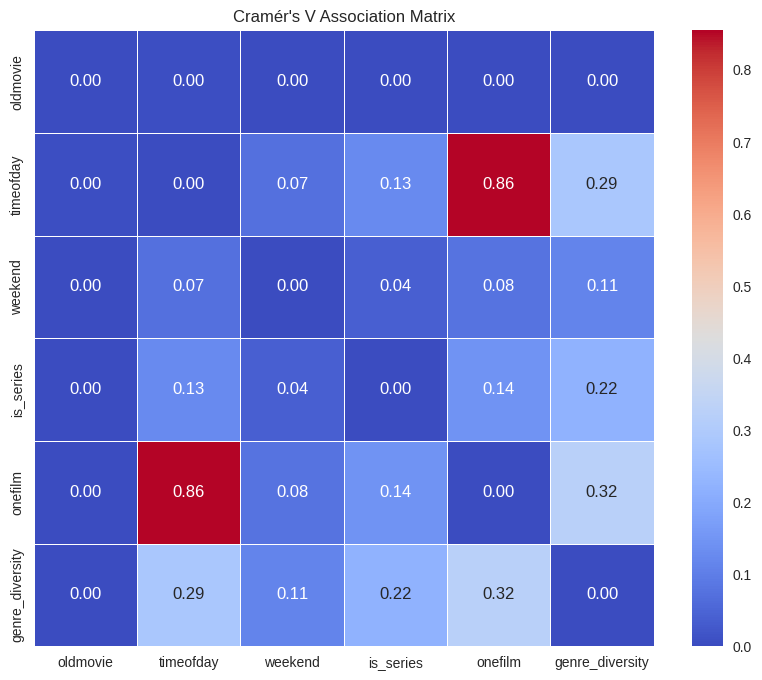

In [30]:
# Identify selected categorical columns
selected_categorical_columns = categorical_var.columns

# Initialize Cramér's V matrix
cramers_v_matrix = pd.DataFrame(index=selected_categorical_columns, columns=selected_categorical_columns)

# Iterate through combinations of variables and compute Cramér's V
for col1, col2 in combinations(categorical_var, 2):
    contingency_table = pd.crosstab(allvariable2[col1], allvariable2[col2])

    # Compute Cramér's V
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    # Assign Cramér's V to the matrix
    cramers_v_matrix.loc[col1, col2] = cramers_v
    cramers_v_matrix.loc[col2, col1] = cramers_v

cramers_v_matrix = cramers_v_matrix.replace({np.nan: 0})
cramers_v_matrix = cramers_v_matrix.astype(float)


# Plotting the Cramér's V matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Cramér's V Association Matrix")
plt.show()

We decide not to drop any categorical variable as none of them has association greater tha 90% with an other variable and morever we hope the can help with some interpretation of user's habits.

# **2.2 dimensionality matrix reduction**

 Now, having ensured a judicious exclusion of variables with high intercorrelations, we lay the groundwork for a more robust and accurate application of matrix reduction. This meticulous preprocessing step contributes to the overall validity of the factor analysis and enhances our ability to uncover meaningful patterns in the mixed data.

## **Normalization**

### 2.2.1 To normalize or not to normalize

This transformation, as shown, contributes to meeting the assumption of normality, a fundamental requirement for following application.


This is why we need to normalize the data. In general there are many more good reason to normalize:
- The mean performs poorly with outliers, which is not ideal as the mean constitutes a core aspect of all studies based on that statistic

- Imagine you have a dataset with features, and one feature has a much larger scale than the others then the mean of that particular feature contributes significantly to the overall mean of the dataset. If this feature is irrelevant or less informative, its inflated contribution to the mean might mislead the model. In regression analysis, the mean of the target variable serves as a fundamental baseline prediction.

- Mean Squared Error (MSE) acts as a pivotal metric, measuring the average squared difference between predicted and actual values. The lower MSE implies superior model performance compared to this basic mean-based prediction.


### Variable-specific comments



In this particular instance, normalization is applied to some features: let's discuss this now.

*  Notably, the units among variables are not omogenous, such as the number of films compared to average_click for instance. This normalization ensures a standardized comparison across diverse features, mitigating the potential bias introduced by varying scales in subsequent analyses.
*   Normalization since we already transformed some variable is maybe less evident. Altough we still consider it important. We're not performing it directly here but inside the library prince.

## **variables identification**

In this study, Factor Analysis of Mixed Data (FAMD) is employed as the chosen analytical approach. The rationale for the selection of FAMD lies in the diverse nature of the dataset, encompassing a mix of numerical and categorical variables. Traditional factor analysis techniques assume that all variables are continuous and follow a normal distribution. However, a combination of quantitative measurements and categorical attributes is present in our dataset. FAMD is particularly well-suited for handling this heterogeneity, allowing hidden patterns and relationships within the data to be unraveled while accommodating both numerical and categorical dimensions. This methodological choice facilitates a comprehensive exploration of the underlying factors contributing to the complexity of the dataset, promoting a more nuanced understanding of the phenomena under investigation.

#### 2.2 reduction method selection and application to our dataset

# FAMD

Here our dataset that has now only 14 variables

In [60]:
allvariable2.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0.000000,False,0.693147,False,3.555348,0.000000,Not Genre Diverse,396.038,9.0,Comedy
1,7.613407,newmovies,3.825840,Afternoon,True,0.000000,True,2.564949,True,2.772589,5.052257,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,0.693147,True,1.945910,True,2.639057,4.667835,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,1.791759,True,2.772589,True,2.639057,3.477911,Genre Diverse,214.389,6.0,Comedy
4,9.176215,newmovies,4.972029,Afternoon,False,1.791759,True,3.295837,True,2.708050,4.984620,Genre Diverse,446.923,6.0,Animation


### Approch

In the following piece of code, the number of components is investigated, and information about the relationships between components and the original features is retrieved. Important indices such as eigenvalue, cumulative eigenvalues, and inertia are evaluated.

Finally, the components are obtained.

In [71]:
# We first perform FAMD with an n/2 number of possible components to get eigenvalues
famd = prince.FAMD(
    n_components=7,
    n_iter=6,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)
famd = famd.fit(allvariable2)

In [72]:
# We store them
eigenvalues= famd.eigenvalues_

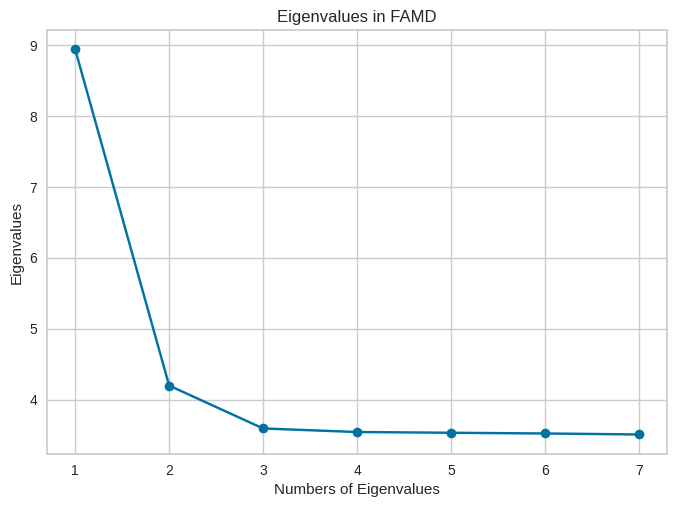

In [74]:
# And plot them
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Eigenvalues in FAMD')
plt.xlabel('Numbers of Eigenvalues')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

By following elbow rule we see 3 is the number of components we may want to keep. Not bad at all as it is a gold number, usually used for graphics visualization

In [75]:
# We first perform FAMD with an n/2 number of possible components to get eigenvalues
famd = prince.FAMD(
    n_components=3,
    n_iter=6,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)
famd = famd.fit(allvariable2)

Eigenvalues show a poor fit. Inertia instead is not bad but shows some problems as well which may relate to collinearity of viceversa with not-linear patterns.

In [83]:
# Here we have the contribution of each features to the components
famd.column_contributions_.style.format('{:.0%}')


component,0,1,2
variable,,,
average_click,0%,0%,0%
averagetime_day,0%,0%,0%
count_notenglish,2%,1%,0%
num_films,5%,2%,0%
avg_lentitle,0%,0%,1%
avg_duration,7%,2%,0%
avg_clickgap,0%,0%,0%
gap_time_avg,0%,0%,0%
first_genre,2%,10%,24%


In [70]:
# We save the component in a matrix
reduced_mat= famd.transform(allvariable2)
reduced_mat.head()

component,0,1,2
0,-4.596886,-0.041423,-0.482182
1,3.518680,-2.329452,0.867967
2,4.022487,-0.578009,-1.552509
3,3.613537,-1.015802,-1.381247
4,4.390502,-4.028080,-0.081960


In [ ]:
reduced_mat.to_json('datasets/famc_3.json', orient='records', lines=True)

## **2.3 Clustering!**


In [ ]:
# Creating Spark session
spark=SparkSession.builder.appName('HW4').getOrCreate()

# Read data from the pca and save it as Pyspark sql dataframe (done in order to get rdds from the dataframes)
df_pysparkfamc3 = spark.read.option('header','true').json('datasets/famc_3.json')

#Create RDD from dataframe
dfrddfamc3 = df_pysparkfamc3.rdd

### **2.3.1: Implement K-means using MapReduce**

The code of the implemented functions can be found in the file '*functions.py*'. Here's a short description of the content of the functions needed to implement the Kmeans algorithm.

To implement the Kmeans algorithm using MapReduce, we divided the algorithm in two steps (the map ine and the reduce one).
The first assigns at each point in the dataset a key-values pair where the key is $i$ s.t. $c_i = \argmin_{c_j\in C} ||x - c||_2^2$ where $C$ is the set of the centroids, and the value is a couple itself: (point, 1).
The reduce phase consists in, after having goruped the points by key, summing in a component-wise way all values of the points that have been assigned to each cluster. This way, for each cluster-label $i$ (the *key* of the Map step), we get the couple  $\big( \sum_{x \in C_i} x, \, \# C_i \big)$ where $C_i$ is the $i$-th cluster. This gives us the possibility to compute the new centroids by multipling the vector in the first entrance for $1/ \# C_i$, so dividing each element of the vector by the value we get as second entrance of the reduce phase output. At this point, we check the convergence of the algorithm by checking if the new centroids are the same as the ones before. If that's not the case, we call recursivly the Kmeans function replacing the starting centroids with the new ones and updating the number of iterations.

### 2.3.2: Find an optimal number of clusters using at least two different methods.

*Method 1*: Elbow method

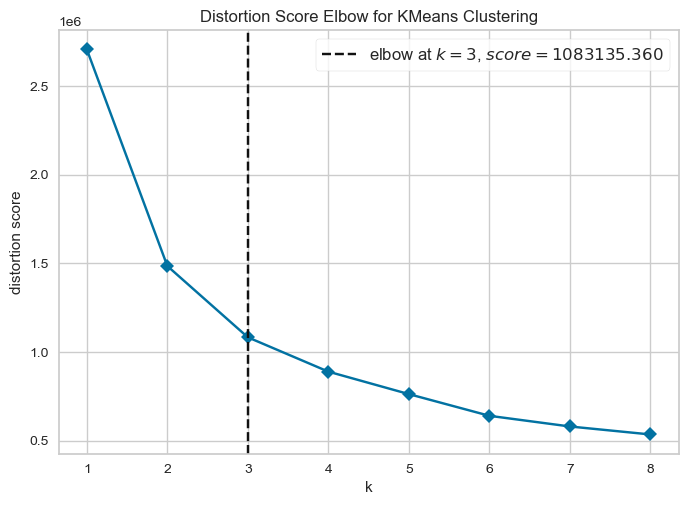

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Reading data from the PCA
data = pd.read_json('datasets/famc_3.json', lines=True)

# Inintialize clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 9),  timings=False, locate_elbow=True) #not showing the time cause it's not relevant since we won't be using the pre-implemented Kmeans algorithm to cluster

# Fit the model
visualizer.fit(data)

# Show results
visualizer.show()

**Method 2. Silhouette coefficient**

100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


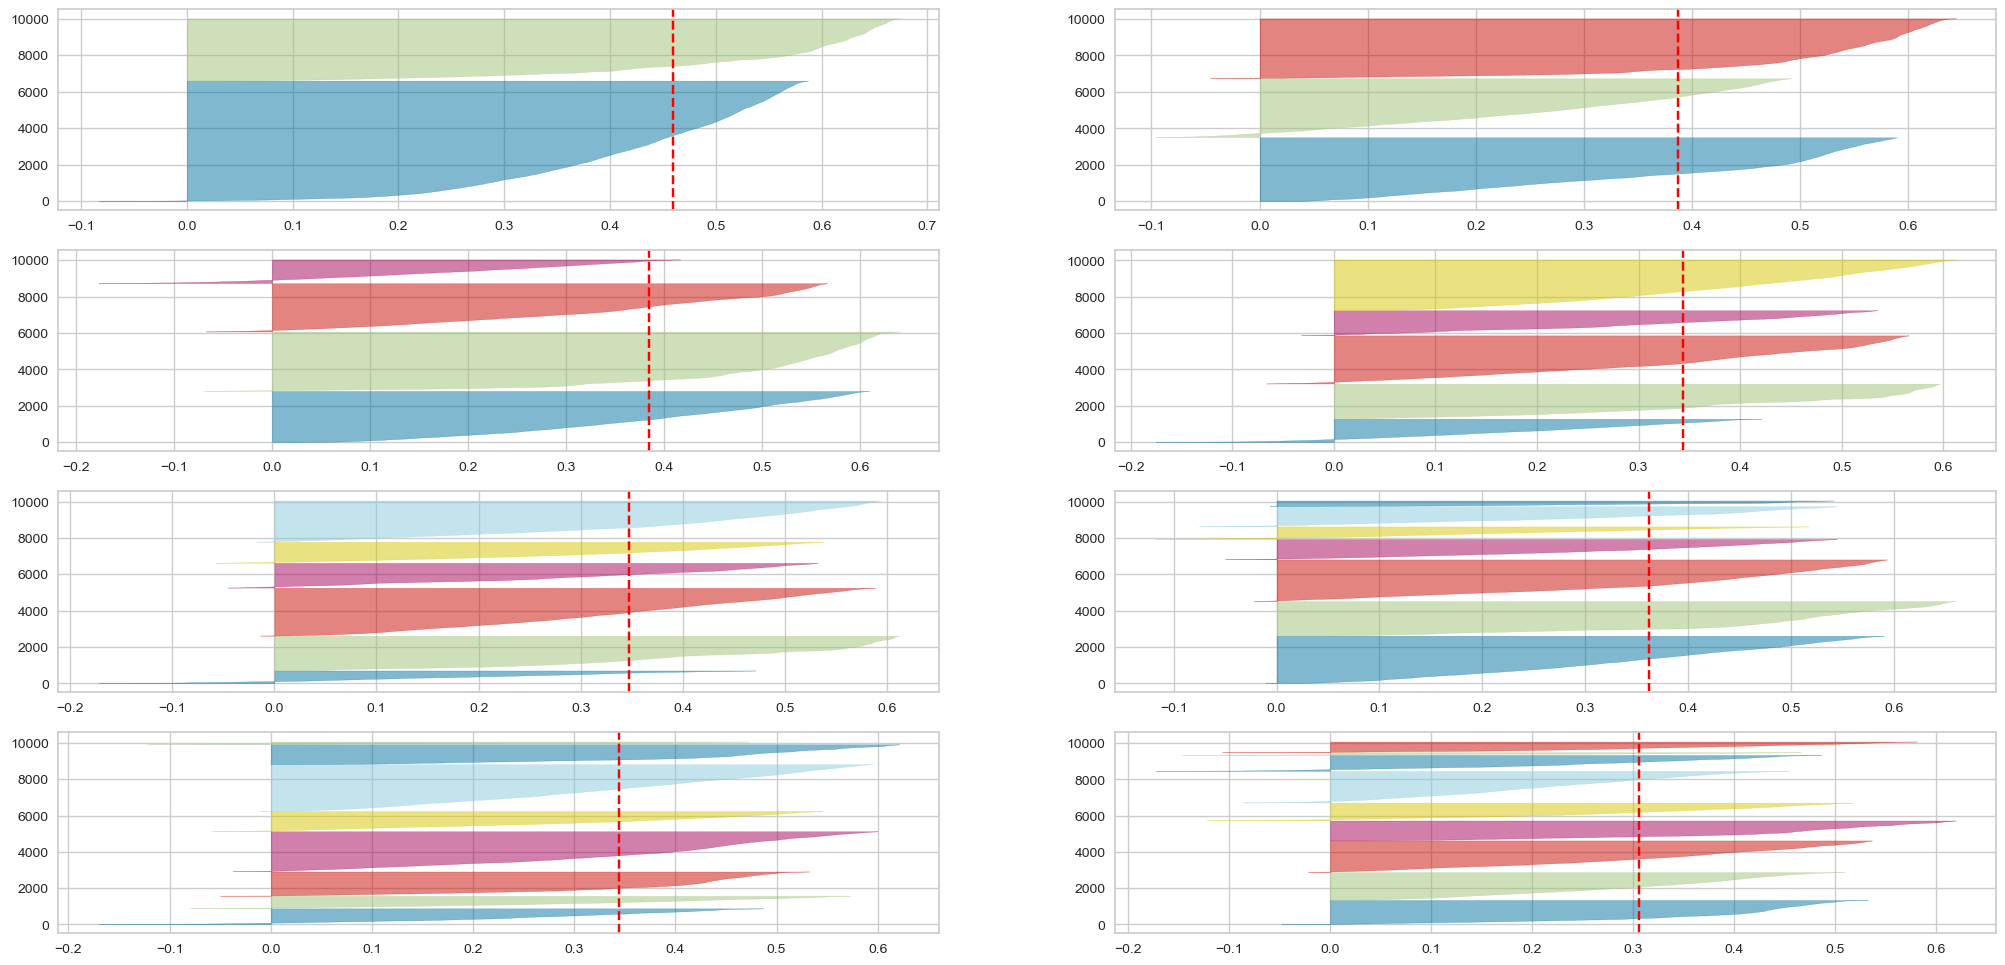

In [ ]:
# Reading data from the pca and taking a sample of it to see the Silhouette score due to computational reasons
data= pd.read_json('datasets/famc_3.json', lines=True)
sample = data.sample(n = 10000)

# Setting plot structure
fig, ax = plt.subplots(4, 2, figsize=(25, 12))

for i in tqdm(range(2, 10)):
    # Performing clustering using the pre-implemented Kmeans algorithm and fixing the number of clusters to i
    km = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)

    # Initializing the visualizer for the silhouette score
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])

    # Computing Silhouette score and visualizing the results
    visualizer.fit(sample)

To choose the appropriate number of clusters we decided to use the Elbow method and the analysis of the Silhouette score.    
For the first method, as can be seen from the plot, we have the the pre-implemented Elbow visualizer detects an elbow at k = 3, but the elbow itself isn't really percievable.
Besides, for the Silhoette score analysis, we can see that the best average score is reached with k=2, but is below 0.5 which make the presence of well distinguished clusters in the data questionable.
Our final choice is to set k=2, following the lead of the Silhouette score, since this method considers not only the intra-cluster variation, but also the between-clusters one.

### **2.3.3: Run the algorithm on the data obtained from the dimensionality reduction**

In [ ]:
#results - FAMC 3, Kmeans with k=2
centroids = functions.extract_starting_centroids(dfrddfamc3, 2)
_, keys3, centroids_final,  niter3 = functions.Kmeans(dfrddfamc3, centroids, 2, 0)

#Insert cluster label in the original dataframe
dftotal3 = pd.read_json('datasets/allvariables.json', lines=True)
dftotal3.insert(0, 'Cluster', keys3)

In [ ]:
print('The number of iterations made by the Kmeans algorithm is:', niter3)
dftotal3

The number of iterations made by the Kmeans algorithm is: 12


,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,1,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,1,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,1,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,0,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,0,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,0,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,1,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


### **2.3.4. Implement K-means++ from scratch and explain the differences with the results you got earlier**

The code of the Kmeans++ implementation can be found in the file '*functions.py*'.

To write the code for the Kmeans++ algorithm, we leverage the fact that the only difference with the Kmeans algorithm it's the computation of the staring centroids: we implmented a new function that computes the starting centroids according the Kmeans ++ algorithm, and use it to compute them, then we call the Kmeans function on these centoids to get the clusters.    
In order to compute the starting centroids we used the pre-implemented function "choices" from the module "random" since it lets us fix the weigths with wich each centroid has to be selected. This serves exactly our purpose since each centroid needs to be calculated accordingly to its minimum distance from the previous ones.

In [ ]:
# Reading the data coming from the FAMC in a pandas dataframe, in oder to be ble to compute the initial centroids of kmeans ++)
df_famc3 = pd.read_json('datasets/famc_3.json', lines=True)

#results - FAMC 3, Kmeans ++
_, keys_pp3, centroids_pp,  niter_pp3 = functions.kmeans_plusplus(dfrddfamc3, df_famc3, 2)

#Insert cluster label in the original dataframe
dftotal3_pp = pd.read_json('datasets/allvariables.json', lines=True)
dftotal3_pp.insert(0, 'Cluster', keys_pp3)

In [ ]:
print('The number of iterations made by the Kmeans++ algorithm is:', niter_pp3)
dftotal3_pp

The number of iterations made by the Kmeans++ algorithm is: 7


,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,1,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,1,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,1,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,0,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,0,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,0,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,1,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


In order to compare the results from the two algorithms (Kmeans and Kmeans++), we did a scatterplot of the data and the resulting centroids. From these plots, we can see that the results we get are the same, except for the order of the clusters. Besides, we can compare the number of iterations made by the two algorithms. For this purpose, by running the algorithm multiple times, we saw that there are no consistent differences between the iterations made by the two algrithms, and that their number goes it's consistently under 10 iterations. For these reasons, we can say that the two algorithms performances are equivalent for this data.

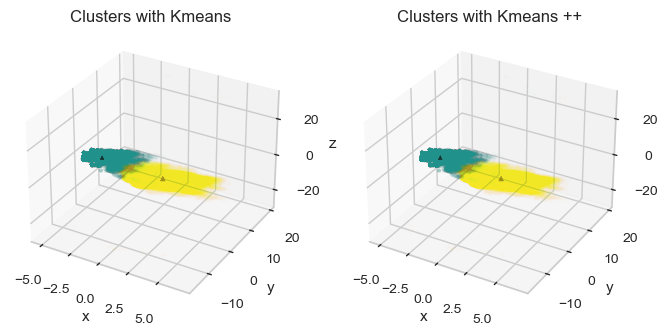

In [ ]:
# Scatterplot of the results from Kmeans and Kmeans ++

# Setting plot environment
data = pd.read_json('datasets/famc_3.json', lines=True)
datav = data.values

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, subplot_kw={'projection': '3d'})

# Kmeans Results
# Setting cluster labels for Kmeans
cluster_labels_kmeans = keys3
n_clusters_kmeans = 2
colors_kmeans = cm.viridis(np.array(cluster_labels_kmeans + np.ones(np.shape(np.array(cluster_labels_kmeans))), dtype=np.float64).astype(float) / n_clusters_kmeans)

# Scatterplot of the data
ax1.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, alpha=0.01, c=colors_kmeans, edgecolor="k"
)

# Centroids of the kmeans
centers_kmeans = np.array(centroids_final, dtype=np.float64)
ax1.scatter(
    centers_kmeans[:, 0],
    centers_kmeans[:, 1],
    centers_kmeans[:, 2],
    marker="^",
    c="black",
    alpha=1,
    s=10,
    edgecolor="k",
)
ax1.set_title('Clusters with Kmeans')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Kmeans ++ Results
# Setting cluster labels for Kmeans ++
cluster_labels_kmeans_pp = keys_pp3
colors_kmeans_pp = cm.viridis(np.array(cluster_labels_kmeans_pp + np.ones(np.shape(np.array(cluster_labels_kmeans_pp))), dtype=np.float64).astype(float) / n_clusters_kmeans)

# Scatterplot of results from Kmeans ++
ax2.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, alpha=0.01, c=colors_kmeans_pp, edgecolor="k"
)

# Centroids for Kmeans ++
centers_kmeans_pp = np.array(centroids_pp, dtype=np.float64)
ax2.scatter(
    centers_kmeans_pp[:, 0],
    centers_kmeans_pp[:, 1],
    centers_kmeans_pp[:, 2],
    marker="^",
    c="black",
    alpha=1,
    s=10,
    edgecolor="k",
)
ax2.set_title('Clusters with Kmeans ++')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.show()


### **2.3.5: ChatGPT recommended clustering algorithm**

First of all, we asked ChatGPT (3.5) to suggest us some clustering algorithms that weren't Kmeans or one of its variants. The answer it gave us was the following:

"Certainly! One alternative to k-means clustering is the Hierarchical Clustering algorithm. Hierarchical clustering builds a tree of clusters, also known as a dendrogram, by successively merging or splitting clusters. There are two main types of hierarchical clustering:

- Agglomerative Hierarchical Clustering:     
    How it works: It starts with individual data points as separate clusters and merges them iteratively based on some similarity measure until only one cluster remains.
    Pros: It does not require the number of clusters to be specified in advance, and the results can be visualized using a dendrogram.
    Cons: It can be computationally expensive for large datasets.

- Divisive Hierarchical Clustering:      
    How it works: It starts with all data points in a single cluster and then splits them into smaller clusters iteratively until each data point is in its own cluster.
    Pros: Similar to agglomerative clustering, it does not require specifying the number of clusters beforehand.
    Cons: It can also be computationally expensive.

- Another alternative is the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm:     
    How it works: DBSCAN groups together data points that are close to each other and identifies outliers as data points that are far from any cluster.
    Pros: It can discover clusters of arbitrary shapes and is robust to outliers. It does not require specifying the number of clusters.
    Cons: It may have difficulty with datasets of varying density, and the results can be sensitive to the choice of parameters.
    These are just a couple of examples, and there are many other clustering algorithms available, each with its strengths and weaknesses. The choice of algorithm depends on the specific characteristics of your data and the goals of your analysis."


We decided to perform the clustering usinf DBSCAN due to the large computational cost of using agglomerative clustering and the fact that we have a dataset that, even after PCA, has nine features. We were also interested to see if DBSCAN identified the points arranged along the horizontal line at elevation (about) -1.7 as one cluster and the remainder as another, since, as ChatGPT mentioned, DBSCAN should identify clusters of each shape, and the one between these two groups seems to be one of the most pronounced divisions within the dataset (at least in terms of the first two principal components, since from the plot we can only see the behavior of the points along these two directions).

To get the code below, we asked ChatGPT to provide us one, then we adjusted it to our needs by loading our data, and deleting the scaling part, since we the data we have is already been normalized. We also added a scatterplot of the results, to be able to visualize them. Besides, to make sure we had good parameters, we asked ChatGPT to provide us a code to select them based on our data.

In [ ]:
parameter_grid = {'eps': [0.5, 1],
                  'min_samples': [100, 500, 1000]}

best_silhouette_score = -1
best_params = None

for eps_value in parameter_grid['eps']:
    for min_samples_value in tqdm(parameter_grid['min_samples']):
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        labels = dbscan.fit_predict(data)
        silhouette = silhouette_score(data, labels)

        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_params = {'eps': eps_value, 'min_samples': min_samples_value}

print("Best Parameters:", best_params)


100%|██████████| 3/3 [11:39<00:00, 233.03s/it]

Best Parameters: {'eps': 1, 'min_samples': 500}


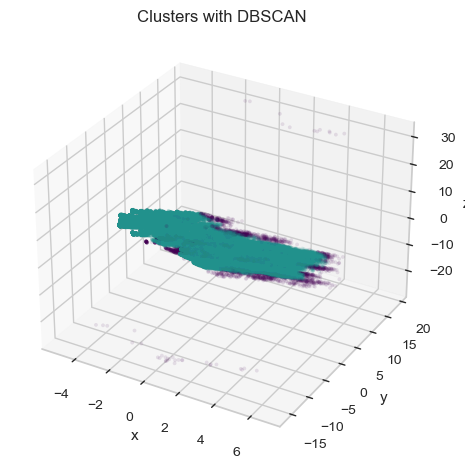

In [ ]:
# Load your preprocessed dataset
data = pd.read_json('datasets/famc_3.json', lines=True)

# Create and fit the DBSCAN model
# The eps parameter controls the maximum distance between two samples for one to be considered as in the neighborhood of the other
# The min_samples parameter sets the number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan.fit(data)

# Access the labels assigned to each data point
labels = dbscan.labels_

# Adding labels to the original dataset, not the one resulting from PCA
originaldata = pd.read_json('datasets/allvariables.json', lines=True)
originaldata.insert(0, 'Cluster', labels)

# Scatterplot of the results
datav = data.values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n_clusters = len(set(labels))

colors = cm.viridis(np.array(labels + np.ones(np.shape(np.array(labels))), dtype=np.float64).astype(float) / n_clusters)

ax.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, c=colors, alpha=0.1, edgecolor="k"
)

plt.title('Clusters with DBSCAN')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()


In [ ]:
datafamc = pd.read_json('datasets/famc_3.json', lines=True).values

# Sampling data and saving the Silhouette score (not on the whole dataset for computational reasons)
silscore = []
for sample_extraction in range(30):
    silscore.append(silhouette_score(datafamc, labels, sample_size = 1000, random_state=100))

# Average Silhouette score as representative of the real one
avg_silscore = sum(silscore)/len(silscore)
print('The Silhouette score for the DBSCAN model is:', round(avg_silscore, 2))

The Silhouette score for the DBSCAN model is: 0.43


From the scatterplot, we can see that even in this case we have two different clusters, but they are not the same as the ones obtained from Kmeans. This makes sense since this clusters are based on the density of the points, and they're not spherical (as the ones formed used Kmeans). The Silhouette score for the two models are comparable, so I don't think one methods performs significantly better than the other one.

## **2.4 Analysing your results!**

In order ot identify the variables that are relevant to the clusters' distincition, we looked at the summary of the features' representation after the dimentionality reduction. Our intuition was that the features which are more represented after this procedure were those that identify clusters. Following this path, we choose to analyze the features '*onefilm*', '*avg_duration*' and '*num_films*'.

Since the second and third feature were divided into four cathegories, using their quantiles. The first one is a binary variable, so we considered only two categories for it, following its natural division given from the value it takes.

**1st variable: *onefilm***

In [ ]:
# Dataset copy to create the pivot table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'onefilm']]

# Summarizing values
pivotpart = dfpivot.groupby('Cluster').agg(list)
takeproportion = lambda l: sum(l)/len(l)
pivotpart['No_films']= pivotpart.onefilm.apply(lambda x: round(takeproportion(x) * 100))
pivotpart['At_least_one_film'] = pivotpart.onefilm.apply(lambda x: round((1 -takeproportion(x)) * 100))

# Dropping unused columns
pivotpart.drop('onefilm', axis=1, inplace=True)

#Showing pivot table
pivotpart

,No_films,At_least_one_film
Cluster,,
0,7,93
1,100,0


Our intuition lead us right with *'onefilm'*: we can see that all the points in one cluster are clients that didn't saw any films, and, on the other hand, the 93% of the clients in the other cluster have seen at least one film. This makes us state that *onefilm* is a relevant variable to distinguish between the clusters.

**3rd variable: *avg_duration***

In [ ]:
# Dataset copy to create table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'avg_duration']]

# Partitioning 'avg_duration' values into four categouries using the quartiles
avg_duration_part = dfpivot.avg_duration.quantile([.25, .5, .75]).values
dfpivot['average_duration_first_quartile'] = dfpivot.avg_duration.apply(lambda row: row <= avg_duration_part[0] )
dfpivot['average_duration_second_quartile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[1]) & (row > avg_duration_part[0]))
dfpivot['average_duration_third_quartile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[2]) & (row > avg_duration_part[1]) )
dfpivot['average_duration_fourth_quartile'] = dfpivot.avg_duration.apply(lambda row: row > avg_duration_part[2] )

# Summarizing the results: getting the percentage of each subcategory
pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.average_duration_first_quartile = pivotpart.average_duration_first_quartile.apply(takepercentage)
pivotpart.average_duration_second_quartile = pivotpart.average_duration_second_quartile.apply(takepercentage)
pivotpart.average_duration_third_quartile = pivotpart.average_duration_third_quartile.apply(takepercentage)
pivotpart.average_duration_fourth_quartile = pivotpart.average_duration_fourth_quartile.apply(takepercentage)

# Dropping unused column
pivotpart.drop('avg_duration', axis=1, inplace=True)

# Showing pivot table
pivotpart

,average_duration_first_quartile,average_duration_second_quartile,average_duration_third_quartile,average_duration_fourth_quartile
Cluster,,,,
0,93,3,2,1
1,0,26,37,37


For *avg_duration*, we have that one cluster contains only points for which this variable has values that are over the first quartile, while the other one has the 93% of the points with *avg_duration* below the first quartile, only 7% of the points with values between the second and the third quartile, and no points above the third one. This draws the threshold for this feature to distinguish between the two clusters to the first quartile. For further investigation, we now want to see which is the minimum of this feature, and how the quartiles are distributed.

In [ ]:
print('The minimum of avg_duration is:', dftotal3.avg_duration.min())
pd.DataFrame(avg_duration_part, index= [0.25, 0.5, 0.75], columns=['Quantiles of avg_duration'] )

The minimum of avg_duration is: 0.0


,Quantiles of avg_duration
0.25,0.00000
0.50,80.93750
0.75,705.56975


We can see that, since 0 is the minimum of the values taken from *avg_duration*, and it's also the first quartile of its distribution, it's reasonable to think that we have at least the 25% of the data with *avg_duration* = 0, and looking at how big the values of the second and third quartile are compared tothat one, we can say that there's a portion of the data that it's separeted from the other due to this value, which is consistent with what we said before.

**3rd variable: *num_films***

In [ ]:
# Dataset copy to compute pivot table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'num_films']]

# Partitioning 'num_films' values into four categouries using the quartiles
num_films_part = dfpivot.num_films.quantile([.25, .5, .75]).values

# Creating new columns that indicate in what interquartile range row['num_film'] is
dfpivot['num_films_first_quartile'] = dfpivot.num_films.apply(lambda row: row <= num_films_part[0] )
dfpivot['num_films_second_quartile'] = dfpivot.num_films.apply(lambda row: (row <= num_films_part[1]) & (row > num_films_part[0]))
dfpivot['num_films_third_quartile'] = dfpivot.num_films.apply(lambda row: (row <= num_films_part[2]) & (row > num_films_part[1]) )
dfpivot['num_films_fourth_quartile'] = dfpivot.num_films.apply(lambda row: row > num_films_part[2] )

# Summarizing the results: getting the percentage of each subcategory
pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.num_films_first_quartile = pivotpart.num_films_first_quartile.apply(takepercentage)
pivotpart.num_films_second_quartile = pivotpart.num_films_second_quartile.apply(takepercentage)
pivotpart.num_films_third_quartile = pivotpart.num_films_third_quartile.apply(takepercentage)
pivotpart.num_films_fourth_quartile = pivotpart.num_films_fourth_quartile.apply(takepercentage)

# Dropping unused column
pivotpart.drop('num_films', axis=1, inplace=True)

# Showing pivot table
pivotpart

,num_films_first_quartile,num_films_second_quartile,num_films_third_quartile,num_films_fourth_quartile
Cluster,,,,
0,67,20,11,1
1,20,18,31,30


As we can see from the pivot, *num_films* seems more relevant to identify one of the two cluster than the other one. Indeed, for the first-mentioned cluster we have that 68% of the clients assigned to it have watched a small (= under the first quartile) number of films, and the percentage of clients assigned to this cluster decreases progressively when looking to the other sections for this feature.
On the other hand, when looking at the percentage of clients assigned to the other cluster in respect to the number of films watched, we can see that they're splitted 40/60 for the first and second half of possible values, and that there is no differences (in terms of percentages) between the first and second quartile, and there's only one point percentage of difference between the third and the fourth one.

**Clustering performance: Silhouette score**

In [ ]:
datafamc = pd.read_json('datasets/famc_3.json', lines=True).values

# Sampling data and saving the Silhouette score (not on the whole dataset for computational reasons)
silscore = []
for sample_extraction in range(30):
    silscore.append(silhouette_score(datafamc, keys3, sample_size = 1000, random_state=100))

# Average Silhouette score as representative of the real one
avg_silscore = sum(silscore)/len(silscore)
print('The Silhouette score for our model is:', round(avg_silscore, 2))

The Silhouette score for our model is: 0.44


The Silhouette score we get is similar to the one gotten using the pre-implemented Kmeans method (computed to decide the number of clusters). As a consequence, the conclusions we get from this score are the same of the ones above: the score we get it's too low to say that we have well-separated clusters, since a reasonable Silhouette score is above 0.5. Anyway, the value is close to 0.44 so we think that there are some recurrent patterns in the data, even though they are not so strong.

# **3. Bonus: Clustering the users using DBSCAN algorithm**

#### The comparison between the K-means and the DBSCAN algorithm was done in section **2.3.5.** In this section, a new approach will be taken to cluster the users based on the genres **only**.

#### **Approach:** Genre-Based User Clustering
##### The clustering is focused on users, leveraging frequency-encoded genres. Only clicks lasting more than 10 minutes are considered to enhance the robustness of our approach against potential miss-clicks.

In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [ ]:
# Create a DataFrame with the frequency of each genre for each user
df_frequency_clustering = pd.DataFrame(index = unique_users, columns=genres_list).fillna(0)
df_frequency_clustering.drop('NOT AVAILABLE', axis=1, inplace=True)
df_frequency_clustering.head()



,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ebf43c36b6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8e1be40e32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cff8ea652a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']

    # Calculate the frequency for each genre
    for genre in genres:
        # Check if the genre is in the DataFrame columns and if the duration is greater than 10 minutes
        if genre in df_frequency_clustering.columns and row['duration'] > 600:
            df_frequency_clustering.loc[user_id, genre] += 1

In [ ]:
df_frequency_clustering.head()

,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,3,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,3,1,1
ebf43c36b6,0,5,1,1,0,0,2,0,0,0,...,0,0,0,1,0,1,0,5,1,0
8e1be40e32,0,4,1,13,0,2,1,0,2,0,...,1,5,0,2,1,3,0,1,1,1
cff8ea652a,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_frequency_clustering)



In [ ]:
# Set epsilon and min_samples parameters
epsilon = 1.3
min_samples = 800

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

# 'clusters' now contains the cluster assignments for each user
df_frequency_clustering['cluster'] = clusters

In [ ]:
df_frequency_clustering.head()

,Adventure,Romance,Horror,News,Musical,Talk-Show,Mystery,Reality-TV,Sport,Thriller,...,Documentary,Short,Film-Noir,Fantasy,War,Western,Music,Animation,Family,cluster
7cbcc791bf,1,1,0,0,0,0,0,0,0,3,...,0,0,0,1,0,0,0,1,1,-1
ebf43c36b6,1,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,2,1,-1
8e1be40e32,1,5,1,0,0,0,0,0,0,4,...,1,0,0,1,2,1,0,1,1,-1
cff8ea652a,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
print('The users were clustered into',len(df_frequency_clustering['cluster'].unique()), 'clusters.')

The users were clustered into 6 clusters.


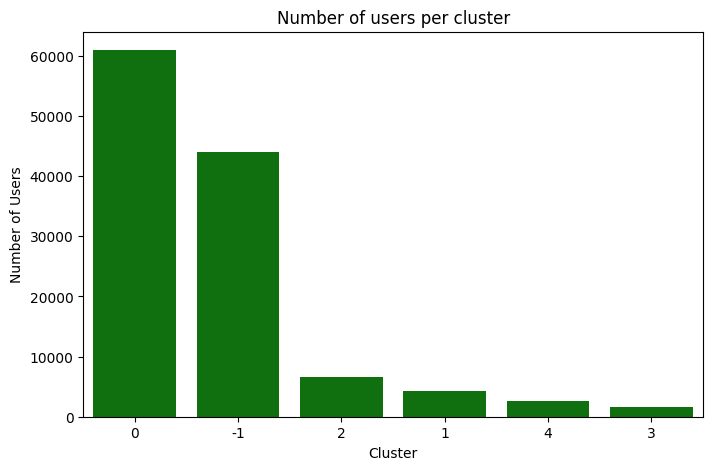

In [ ]:
# plot the top 10 clusters
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df_frequency_clustering, order=df_frequency_clustering['cluster'].value_counts().iloc[:10].index, color='green')
plt.title('Number of users per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

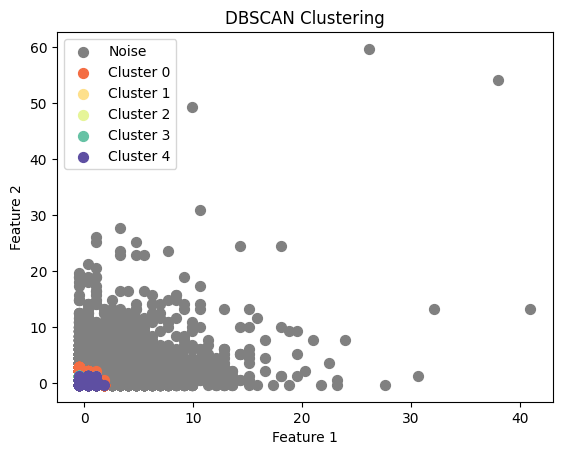

In [ ]:
# Assign a unique color to each cluster (including noise points, labeled as -1)
unique_labels = np.unique(clusters)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        plt.scatter(scaled_data[clusters == label, 0], scaled_data[clusters == label, 1], color='gray', s=50, label='Noise')
    else:
        plt.scatter(scaled_data[clusters == label, 0], scaled_data[clusters == label, 1], color=color, s=50, label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

##### **Comment**

- The users were clustered using DBSCAN into 6 clusters.
- The hyperparameters epsilon and minimum number of samples were tuned to minimize the number of clusters. However, there resulted in many point were considered as noise and also the clusters are not well-separated.


# **4. Command Line Question**

1. What is the most-watched Netflix title?
- Our code:  
`awk -F, '$3 != 0 {print $4}' vodclickstream_uk_movies_03.csv | sort | uniq -c| sort -nr| head -n 1`  

`-F,`: tells awk to use a comma as the field separator.   
`$3 != 0`: a condition that checks if the third field is not zero  
`{print $4}`: an action that prints the fourth field if the condition is true.  
`sort`: sorts the lines in ascending order.  
`uniq -c`: removes duplicate lines and prefixes each line with the number of occurrences.  
`sort -nr`: sorts the lines in numerical order in reverse order, which means in descending order.  
`head -n 1`: prints the first line of the output.

The output we get is: `2884 Black Mirror: Bandersnatch`

2. Report the average time between subsequent clicks on Netflix.com.
- Our code:  
`seconds=$(awk -F, '{sum+=$3} END {print sum/NR}' vodclickstream_uk_movies_03.csv)`  
     `echo "The average time between subsequent clicks on Netflix.com in seconds is: $seconds"`
     
`seconds=$`: assigns the output of the `awk` command to the seconds variable.   
`{sum+=$3}`: adds the value in the third column of each line to the sum variable.  
` END {print sum/NR}` : prints the average of the third column after all lines have been processed.  
`NR`: a built-in variable in awk that holds the number of records processed, which is the total number of lines in the file in this case.  
`echo "The average time between subsequent clicks on Netflix.com in seconds is: $seconds"` : prints a string that includes the value of the `seconds` variable.

The output we get is: `The average time between subsequent clicks on Netflix.com in seconds is: 33476`

3. Provide the ID of the user that has spent the most time on Netflix.
- Our code:   
`user=$(awk -F, '{sum[$NF]+=$3} END {max=0; for (i in sum) if (sum[i]>max) {max=sum[i]; max_id=i} print max_id}' vodclickstream_uk_movies_03.csv)`

     `echo "The ID of the user that has spent the most time on Netflix is: $user"`

`user=$`: assigns the output of the `awk` command to the user variable.  
`{sum[$NF]+=$3}`: adds the value in the third column of each line to the sum array using the value in the last field (the user ID) as the index.   
`END {max=0; for (i in sum) if (sum[i]>max) {max=sum[i]; max_id=i} print max_id}`: iterates over the sum array after all lines have been processed, finds the user ID with the highest sum, and prints this user ID.  
`echo "The ID of the user that has spent the most time on Netflix is: $user"`: prints a string that includes the value of the `user` variable.

The output we get is: `The ID of the user that has spent the most time on Netflix is: 322abe045c`

## Schreenshot of the output

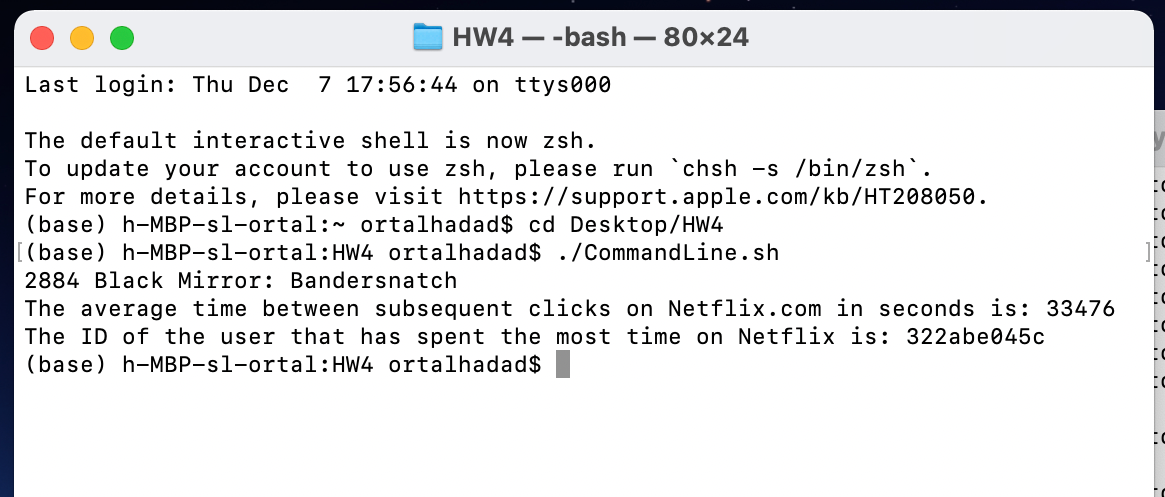

# **5. Algorithmic Question**


First we will consider the Brute-force algorithm which go over all the possible scores and return the maximal one.    
This is clearly not the optimal solution because in this case we have running time of order O(n!)- which is higher than exponential !!  

In [ ]:
#brute force solution

def exams_score(score, exams):
    if len(exams) == 1:
        return exams[0]
    else:
        return max([exams_score(element, [x + (score - element) for x in exams if x != element]) for element in exams])

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
exams_score(score, arr)

Enter initial personal score: 25
Enter exams marks: 18 24 21 32 27


44

## Optimal Implementation
The following solution is the **optimal one:**

In [ ]:
#optimized implementation
import math

def max_score(score, arr):
    if len(arr) == 0:
        return score
    index = math.ceil(len(arr) / 2) - 1
    next_score = arr[index]
    return max_score_calc(next_score, [x + (score - next_score) for x in arr if x != next_score])

def max_score_calc(score, arr):
    return max_score(score, sorted(arr))

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
max_score_calc(score, arr)

Enter initial personal score: 30
Enter exams marks: 13 27 41 59 28 33 39 19 52 48 55 79


205

## Proof of Correctness

**Base Case**: The base case is when the array `arr` is empty, n = 0. In this case, the function max_score returns the initial score `score`, which is correct because there are no more exams to take.

**Inductive Hypothesis**: Assume that the algorithm works correctly for an array of size n. This means that the algorithm correctly calculates the maximum possible score for an array of size n.

**Inductive Step**: The algorithm always chooses the middle element of the array as the next score, and then recursively calculates the maximum score for the remaining elements. Since the remaining elements are a subset of the original array, and we have assumed that the algorithm works correctly for an array of length n, it follows that the algorithm also works correctly for an array of length n+1

## Running time - Optimal Solution
Denote n as the length of our input array 'arr'.
We will prove our algorithm run in O(n *log(n)):

First note thet we are calling the `max_score_calc` that send our input score and the sorted version of our array into the `max_score` function.
- `max_score(score, sorted(arr))` - The sorted() function has a time complexity of O(n log n)

Afterward for the function `max_score` we have:
- `if len(arr) == 0` : The algorithm first checks if the array is empty. This operation has a constant time complexity of O(1).
- `index = math.ceil(len(arr) / 2) - 1` : Selects the index of middle element of the array using len and ceil takes O(1).
- `next_score = arr[index]` : Selecting an element from a sorted array has a time complexity of O(1).  
- `max_score_calc(next_score, [x + (score - next_score) for x in arr if x != next_score])`: Now we call our function in a recursive way with len(arr) = N-1. Also note that we change each element in the new array this is done by going over all elements in the array which takes O(n) and in the next recursive call this will take O(n- 1), since the length of the new input array decrease.  
Therfore the overall running time of `max_score` is O(n + (n-1) + (n-2) + ... + 1) < O( c * n) = O(n).

So we get our algorithm has running time of O(n log(n) + n) = O(n log(n)).  

This implementation is the optimal one since in order to solve the question me must sort the given array which takes at least O(n log(n)).

## AI third implementation

The following code is the implementation suggested by chatGPT.
The running time of this code is explained as follow:

In this code, S is the initial score and exams is a list of exam marks. The function max_score returns the maximum possible score. The time complexity of this solution is O(N^2), where N is the number of exams. This is because for each exam, we are iterating over all the previous exams to calculate the maximum possible score. The space complexity is O(N), which is used to store the dynamic programming table dp.


In [ ]:
def max_score_ai(S, exams):
    exams.sort(reverse=True)
    dp = [0]*len(exams)
    for i in range(len(exams)):
        for j in range(i):
            if exams[i] > exams[j]:
                dp[i] = max(dp[i], dp[j] + exams[i] - exams[j])
            else:
                dp[i] = max(dp[i], dp[j] + S - exams[i])
        dp[i] = max(dp[i], exams[i])
    return dp[-1]

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
max_score_ai(score, arr)

Enter initial personal score: 30
Enter exams marks:  13 27 41 59 28 33 39 19 52 48 55 79


112

Clearly the algorithm is wrong since the Max_score for the input given is 205 and not 112.